# Vaccines and patient characteristics

### Import libraries and data

The datasets used for this report are created using the study definition [`/analysis/study_definition.py`](../analysis/study_definition.py), using codelists referenced in [`/codelists/codelists.txt`](../codelists/codelists.txt). 

In [1]:
%load_ext autoreload
%autoreload 2
 
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import subprocess
from IPython.display import display, Markdown, HTML
import os

suffix = "_tpp"

# get current branch
current_branch = subprocess.run(["git", "rev-parse", "--abbrev-ref", "HEAD"], capture_output=True).stdout.decode("utf8").strip()

### Import our custom functions

In [2]:
# import custom functions from 'lib' folder
import sys
sys.path.append('../lib/')

In [3]:
from data_processing import load_data

In [4]:
from report_results import find_and_save_latest_date, create_output_dirs

In [5]:
# create output directories to save files into 
savepath, savepath_figure_csvs, savepath_table_csvs = create_output_dirs()

### Load and Process the raw data 

In [6]:
df = load_data()

In [7]:
latest_date, formatted_latest_date = find_and_save_latest_date(df, savepath=savepath)

In [8]:
print(f"Latest Date: {formatted_latest_date}")

Latest Date: 03 Sep 2021


### Summarise by group and demographics at latest date

#### Calculate cumulative sums at each date and select latest date + previous figures for comparison

In [9]:
from report_results import cumulative_sums

In [10]:
# population subgroups - in a dict to indicate which field to filter on


population_subgroups = {"80+":1,
        "70-79":2, 
        "care home":3, 
        "shielding (aged 16-69)":4, 
        "65-69": 5,  
        "LD (aged 16-64)": 6,  
        "60-64": 7,
        "55-59": 8,
        "50-54": 9,
        "40-49": 10,
        "30-39": 11,
        "18-29": 12,                
        "16-17": 0 
        # NB if the population denominator is not included for the final group (0), the key must contain phrase "not in other eligible groups" so that data is presented appropriately
        }

groups = population_subgroups.keys()


#  list demographic/clinical factors to include for given group
DEFAULT = ["sex","ageband_5yr","ethnicity_6_groups","ethnicity_16_groups", "imd_categories", 
                              "bmi", "chronic_cardiac_disease", "current_copd", "dialysis", "dmards", "dementia",
                              "psychosis_schiz_bipolar","LD","ssri",
                              "chemo_or_radio", "lung_cancer", "cancer_excl_lung_and_haem", "haematological_cancer"]
#for specific age bands remove features which are included elsehwere or not prevalent
o65 = [d for d in DEFAULT if d not in ("ageband_5yr", "dialysis")]
o60 = [d for d in DEFAULT if d not in ("ageband_5yr", "dialysis", "LD")]
o50 = [d for d in DEFAULT if d not in ("ageband_5yr", "dialysis", "LD", "dementia",
                                       "chemo_or_radio", "lung_cancer", "cancer_excl_lung_and_haem", "haematological_cancer"
                                      )]
# under50s
u50 = ["sex", "ethnicity_6_groups", "ethnicity_16_groups","imd_categories"]

# dictionary mapping population subgroups to a list of demographic/clinical factors to include for that group
features_dict = {0:    u50, ## patients not assigned to a priority group
                 "care home": ["sex", "ageband_5yr", "ethnicity_6_groups", "dementia"],
                 "shielding (aged 16-69)": ["newly_shielded_since_feb_15", "sex", "ageband", "ethnicity_6_groups", "imd_categories",
                                           "LD"],
                 "65-69":    o65,
                 "60-64":    o60,
                 "55-59":    o50,
                 "50-54":    o50,
                 "40-49":    u50,
                 "30-39":    u50,
                 "18-29":    u50,
                 "16-17":    ["sex", "ethnicity_6_groups", "imd_categories"],
                 "LD (aged 16-64)":  ["sex", "ageband_5yr", "ethnicity_6_groups"],
                 "DEFAULT":   DEFAULT # other age groups
                }


In [11]:
df_dict_cum = cumulative_sums(df, groups_of_interest=population_subgroups, features_dict=features_dict, latest_date=latest_date)

In [12]:
# for details on second doses, no need for breakdowns of any groups (only "overall" figures will be included)
second_dose_features = {}
for g in groups:
    second_dose_features[g] = []

df_dict_cum_second_dose = cumulative_sums(df, groups_of_interest=population_subgroups, features_dict=second_dose_features, 
                                          latest_date=latest_date, reference_column_name="covid_vacc_second_dose_date")

### Cumulative vaccination figures - overall

In [13]:
from report_results import make_vaccine_graphs

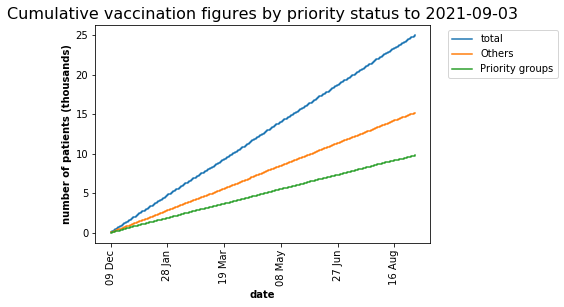

In [14]:
make_vaccine_graphs(df, latest_date=latest_date, grouping="priority_status", savepath_figure_csvs=savepath_figure_csvs, savepath=savepath, suffix=suffix)

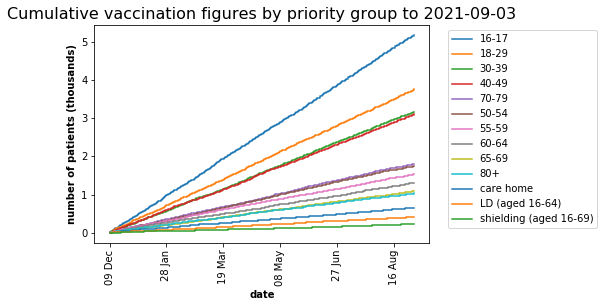

In [15]:
make_vaccine_graphs(df, latest_date=latest_date, include_total=False, savepath=savepath, savepath_figure_csvs=savepath_figure_csvs, suffix=suffix)

### Reports 

In [16]:
from report_results import summarise_data_by_group

In [17]:
summarised_data_dict = summarise_data_by_group(df_dict_cum, latest_date=latest_date, groups=groups)

In [18]:
summarised_data_dict_2nd_dose = summarise_data_by_group(df_dict_cum_second_dose, latest_date=latest_date, groups=groups)

### Proportion of each eligible population vaccinated to date

In [19]:
from report_results import create_summary_stats, create_detailed_summary_uptake

In [20]:
summ_stat_results, additional_stats = create_summary_stats(df, summarised_data_dict, formatted_latest_date, groups=groups, 
                                         savepath=savepath, suffix=suffix)

In [21]:
summ_stat_results_2nd_dose, _ = create_summary_stats(df, summarised_data_dict_2nd_dose, formatted_latest_date, 
                                                  groups=groups, savepath=savepath, 
                                                  vaccine_type="second_dose", suffix=suffix)

In [22]:
# display the results of the summary stats on first and second doses
display(pd.DataFrame(summ_stat_results).join(pd.DataFrame(summ_stat_results_2nd_dose)))    
display(Markdown(f"*\n figures rounded to nearest 7"))

,first dose as at 03 Sep 2021,second dose as at 03 Sep 2021
Total vaccinated in TPP,"24,997","15,001"
80+,"50.2% (1,029 of 2,051)","30.6% (630 of 2,051)"
70-79,"49.7% (1,806 of 3,633)","30.5% (1,106 of 3,633)"
care home,"47.8% (651 of 1,365)","29.1% (399 of 1,365)"
shielding (aged 16-69),52.9% (224 of 427),31.1% (133 of 427)
65-69,"50.3% (1,092 of 2,177)","28.7% (623 of 2,177)"
LD (aged 16-64),49.6% (406 of 812),30.5% (245 of 812)
60-64,"48.4% (1,309 of 2,702)","29.5% (798 of 2,702)"
55-59,"51.3% (1,533 of 2,982)","28.9% (861 of 2,982)"
50-54,"50.7% (1,743 of 3,437)","30.7% (1,057 of 3,437)"


*
 figures rounded to nearest 7

In [23]:
# other information on vaccines

for x in additional_stats.keys():
    display(Markdown(f"{x}: {additional_stats[x]}"))
    
display(Markdown(f"*\n figures rounded to nearest 7"))

Oxford-AZ vaccines (% of all first doses): **0.0%** (7)

Pfizer vaccines (% of all first doses): **0.1%** (28)

Moderna vaccines (% of all first doses): **0.0%** (0)

Second doses (% of all vaccinated): **60.0%** (15,001)

Second doses (% of Ox-AZ first doses): **97600.0%** (6,832)

Second doses (% of Pfizer first doses): **18975.0%** (5,313)

Second doses (% of Moderna first doses): **0%** (7,063)

Mixed doses Ox-AZ + Pfizer (% of fully vaccinated): **0.0%** (0)

Mixed doses Ox-AZ + Moderna (% of fully vaccinated): **0.0%** (0)

Mixed doses Moderna + Pfizer (% of fully vaccinated): **0.0%** (0)

*
 figures rounded to nearest 7

# Detailed summary of coverage among population groups as at latest date

In [24]:
create_detailed_summary_uptake(summarised_data_dict, formatted_latest_date, 
                               groups=population_subgroups.keys(),
                               savepath=savepath)

## 

## COVID vaccination rollout (first dose) among **80+** population up to 03 Sep 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    1029   
sex                       F                                           518   
                          M                                           511   
ageband_5yr               0                                            14   
                          0-15                                         63   
                          16-17                                        84   
                          18-29                                        70   
                          30-34                                        56   
                          35-39                                        56   
                          40-44                                        70   
                          45-49                                        70   
                          50-54                                        63   
                          55-59                                        56   
                          60-64                                        63   
                          65-69                                        84   
                          70-74                                        70   
                          75-79                                        63   
                          80-84                                        63   
                          85-89                                        70   
                          90+                                          14   
ethnicity_6_groups        Black                                       168   
                          Mixed                                       175   
                          Other                                       203   
                          South Asian                                 175   
                          Unknown                                     147   
                          White                                       168   
ethnicity_16_groups        African                                     63   
                           Bangladeshi or British Bangladeshi          56   
                           Caribbean                                   56   
                           Chinese                                     56   
                           Other                                       56   
                           Other Asian                                 56   
                          British or Mixed British                     49   
                          Indian or British Indian                     63   
                          Irish                                        49   
                          Other Black                                  63   
                          Other White                                  63   
                          Other mixed                                  49   
                          Pakistani or British Pakistani               49   
                          Unknown                                     147   
                          White + Asian                                63   
                          White + Black African                        56   
                          White + Black Caribbean                      42   
imd_categories            1 Most deprived                             210   
                          2                                           175   
                          3                                           203   
                          4                                           210   
                          5 Least deprived                            189   
                          Unknown                                      42   
bmi                       30+                                         301   
                          under 30                         

## 

## COVID vaccination rollout (first dose) among **70-79** population up to 03 Sep 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    1804   
sex                       F                                           910   
                          M                                           896   
ageband_5yr               0                                            28   
                          0-15                                        119   
                          16-17                                       140   
                          18-29                                       105   
                          30-34                                       119   
                          35-39                                       112   
                          40-44                                       112   
                          45-49                                       133   
                          50-54                                       105   
                          55-59                                       119   
                          60-64                                       105   
                          65-69                                       119   
                          70-74                                       126   
                          75-79                                       112   
                          80-84                                       112   
                          85-89                                       119   
                          90+                                          21   
ethnicity_6_groups        Black                                       308   
                          Mixed                                       301   
                          Other                                       301   
                          South Asian                                 308   
                          Unknown                                     273   
                          White                                       315   
ethnicity_16_groups        African                                     98   
                           Bangladeshi or British Bangladeshi         105   
                           Caribbean                                   91   
                           Chinese                                    126   
                           Other                                       84   
                           Other Asian                                 70   
                          British or Mixed British                    105   
                          Indian or British Indian                     84   
                          Irish                                       105   
                          Other Black                                  98   
                          Other White                                  84   
                          Other mixed                                  91   
                          Pakistani or British Pakistani              105   
                          Unknown                                     259   
                          White + Asian                               112   
                          White + Black African                        84   
                          White + Black Caribbean                     105   
imd_categories            1 Most deprived                             371   
                          2                                           343   
                          3                                           308   
                          4                                           343   
                          5 Least deprived                            343   
                          Unknown                                      98   
bmi                       30+                                         539   
                          under 30                         

## 

## COVID vaccination rollout (first dose) among **care home** population up to 03 Sep 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category           group                                     
overall            overall             653     47.8   1365   
sex                F                   336     46.6    721   
                   M                   322     50.0    644   
ageband_5yr        0                    14     50.0     28   
                   0-15                 35     45.5     77   
                   16-17                49     50.0     98   
                   18-29                42     50.0     84   
                   30-34                42     54.5     77   
                   35-39                42     50.0     84   
                   40-44                56     47.1    119   
                   45-49                28     36.4     77   
                   50-54                35     50.0     70   
                   55-59                35     45.5     77   
                   60-64                42     46.2     91   
                   65-69                42     46.2     91   
                   70-74                49     46.7    105   
                   75-79                42     50.0     84   
                   80-84                49     50.0     98   
                   85-89                42     46.2     91   
                   90+                  14     66.7     21   
ethnicity_6_groups Black               119     50.0    238   
                   Mixed               112     48.5    231   
                   Other               119     51.5    231   
                   South Asian          91     41.9    217   
                   Unknown             105     51.7    203   
                   White               119     48.6    245   
dementia           no                  651     48.2   1351   
                   yes                   0      0.0     14   

                               vaccinated 7d previous (percent)  \
category           group                                          
overall            overall                                 46.7   
sex                F                                       45.6   
                   M                                       47.8   
ageband_5yr        0                                         50   
                   0-15                                    45.5   
                   16-17                                   42.9   
                   18-29                                     50   
                   30-34                                   54.5   
                   35-39                                     50   
                   40-44                                   47.1   
                   45-49                                   36.4   
                   50-54                                     50   
                   55-59                                   45.5   
                   60-64                                   46.2   
                   65-69                                   46.2   
                   70-74                                     40   
                   75-79                                     50   
                   80-84                                     50   
                   85-89                                   46.2   
                   90+                                     66.7   
ethnicity_6_groups Black                                   47.1   
                   Mixed                                   45.5   
                   Other                                   48.5   
                   South Asian                             41.9   
                   Unknown                                 51.7   
                   White                                   45.7   
dementia           no                                      46.6   
                   yes                                        0   

                               Uptake over last 7d (percent)  \
category           group                                       
overall            overall      

## 

## COVID vaccination rollout (first dose) among **shielding (aged 16-69)** population up to 03 Sep 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category                    group                                          
overall                     overall                  226     52.9    427   
newly_shielded_since_feb_15 no                       224     53.3    420   
                            yes                        0      0.0      0   
sex                         F                        112     51.6    217   
                            M                        112     53.3    210   
ageband                     16-29                     21     42.9     49   
                            30-39                     28     50.0     56   
                            40-49                     28     57.1     49   
                            50-59                     28     57.1     49   
                            60-69                     35     62.5     56   
                            70-79                     70     58.8    119   
                            80+                       21     50.0     42   
ethnicity_6_groups          Black                     28     36.4     77   
                            Mixed                     42     60.0     70   
                            Other                     42     54.5     77   
                            South Asian               35     50.0     70   
                            Unknown                   35     55.6     63   
                            White                     42     54.5     77   
imd_categories              1 Most deprived           35     45.5     77   
                            2                         35     45.5     77   
                            3                         49     58.3     84   
                            4                         42     50.0     84   
                            5 Least deprived          49     58.3     84   
                            Unknown                   14     66.7     21   
LD                          no                       224     52.5    427   
                            yes                        0      0.0      0   

                                             vaccinated 7d previous (percent)  \
category                    group                                               
overall                     overall                                      50.8   
newly_shielded_since_feb_15 no                                           51.7   
                            yes                                           NaN   
sex                         F                                            51.6   
                            M                                              50   
ageband                     16-29                                        42.9   
                            30-39                                          50   
                            40-49                                        42.9   
                            50-59                                        42.9   
                            60-69                                        62.5   
                            70-79                                        52.9   
                            80+                                            50   
ethnicity_6_groups          Black                                        36.4   
                            Mixed                                          60   
                            Other                                        54.5   
                            South Asian                                    40   
                            Unknown                                      55.6   
                            White                                        45.5   
imd_categories              1 Most deprived                              45.5   
                            2                                            45.5   
                            3                                            58.3   
                            4                         

## 

## COVID vaccination rollout (first dose) among **65-69** population up to 03 Sep 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    1094   
sex                       F                                           581   
                          M                                           511   
ethnicity_6_groups        Black                                       182   
                          Mixed                                       182   
                          Other                                       203   
                          South Asian                                 182   
                          Unknown                                     175   
                          White                                       168   
ethnicity_16_groups        African                                     63   
                           Bangladeshi or British Bangladeshi          49   
                           Caribbean                                   63   
                           Chinese                                     56   
                           Other                                       56   
                           Other Asian                                 63   
                          British or Mixed British                     56   
                          Indian or British Indian                     70   
                          Irish                                        63   
                          Other Black                                  49   
                          Other White                                  49   
                          Other mixed                                  77   
                          Pakistani or British Pakistani               63   
                          Unknown                                     175   
                          White + Asian                                49   
                          White + Black African                        56   
                          White + Black Caribbean                      35   
imd_categories            1 Most deprived                             203   
                          2                                           224   
                          3                                           189   
                          4                                           210   
                          5 Least deprived                            203   
                          Unknown                                      56   
bmi                       30+                                         343   
                          under 30                                    749   
chronic_cardiac_disease   no                                         1085   
                          yes                                          14   
current_copd              no                                         1085   
                          yes                                           7   
dmards                    no                                         1085   
                          yes                                           7   
dementia                  no                                         1085   
                          yes                                           7   
psychosis_schiz_bipolar   no                                         1085   
                          yes                                          14   
LD                        no                                         1078   
                          yes                                          14   
ssri                      no                                         1085   
                          yes                                           7   
chemo_or_radio            no                                         1085   
                          yes                                          14   
lung_cancer               no                               

## 

## COVID vaccination rollout (first dose) among **LD (aged 16-64)** population up to 03 Sep 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category           group                                     
overall            overall             403     49.6    812   
sex                F                   210     49.2    427   
                   M                   196     50.0    392   
ageband_5yr        0                     0      0.0      7   
                   0-15                 28     50.0     56   
                   16-17                28     57.1     49   
                   18-29                35     62.5     56   
                   30-34                28     57.1     49   
                   35-39                21     42.9     49   
                   40-44                21     42.9     49   
                   45-49                35     62.5     56   
                   50-54                28     44.4     63   
                   55-59                28     57.1     49   
                   60-64                21     42.9     49   
                   65-69                35     62.5     56   
                   70-74                21     42.9     49   
                   75-79                21     33.3     63   
                   80-84                28     57.1     49   
                   85-89                35     50.0     70   
                   90+                   0      0.0      0   
ethnicity_6_groups Black                70     55.6    126   
                   Mixed                70     47.6    147   
                   Other                56     40.0    140   
                   South Asian          77     55.0    140   
                   Unknown              84     57.1    147   
                   White                49     43.8    112   

                               vaccinated 7d previous (percent)  \
category           group                                          
overall            overall                                   49   
sex                F                                       47.5   
                   M                                       48.2   
ageband_5yr        0                                          0   
                   0-15                                      50   
                   16-17                                   57.1   
                   18-29                                   62.5   
                   30-34                                   57.1   
                   35-39                                   42.9   
                   40-44                                   42.9   
                   45-49                                   62.5   
                   50-54                                   44.4   
                   55-59                                   57.1   
                   60-64                                   42.9   
                   65-69                                   62.5   
                   70-74                                   42.9   
                   75-79                                   33.3   
                   80-84                                   57.1   
                   85-89                                     50   
                   90+                                      NaN   
ethnicity_6_groups Black                                   55.6   
                   Mixed                                   47.6   
                   Other                                     40   
                   South Asian                               55   
                   Unknown                                 57.1   
                   White                                   43.8   

                               Uptake over last 7d (percent)  \
category           group                                       
overall            overall                               0.6   
sex                F                                     1.7   
                   M                                     1.8   
ageband_5yr        0                                       0   
                   0-15           

## 

## COVID vaccination rollout (first dose) among **60-64** population up to 03 Sep 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    1309   
sex                       F                                           665   
                          M                                           644   
ethnicity_6_groups        Black                                       203   
                          Mixed                                       238   
                          Other                                       217   
                          South Asian                                 238   
                          Unknown                                     196   
                          White                                       217   
ethnicity_16_groups        African                                     70   
                           Bangladeshi or British Bangladeshi          77   
                           Caribbean                                   63   
                           Chinese                                     63   
                           Other                                       70   
                           Other Asian                                 84   
                          British or Mixed British                     56   
                          Indian or British Indian                     63   
                          Irish                                        70   
                          Other Black                                  70   
                          Other White                                  56   
                          Other mixed                                  63   
                          Pakistani or British Pakistani               77   
                          Unknown                                     210   
                          White + Asian                                70   
                          White + Black African                        70   
                          White + Black Caribbean                      77   
imd_categories            1 Most deprived                             245   
                          2                                           252   
                          3                                           231   
                          4                                           259   
                          5 Least deprived                            259   
                          Unknown                                      63   
bmi                       30+                                         371   
                          under 30                                    938   
chronic_cardiac_disease   no                                         1295   
                          yes                                          14   
current_copd              no                                         1302   
                          yes                                           7   
dmards                    no                                         1295   
                          yes                                          14   
dementia                  no                                         1295   
                          yes                                          14   
psychosis_schiz_bipolar   no                                         1295   
                          yes                                          14   
ssri                      no                                         1295   
                          yes                                          14   
chemo_or_radio            no                                         1295   
                          yes                                          14   
lung_cancer               no                                         1302   
                          yes                                           7   
cancer_excl_lung_and_haem no                               

## 

## COVID vaccination rollout (first dose) among **55-59** population up to 03 Sep 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                    1531   
sex                     F                                           812   
                        M                                           721   
ethnicity_6_groups      Black                                       252   
                        Mixed                                       273   
                        Other                                       266   
                        South Asian                                 266   
                        Unknown                                     231   
                        White                                       245   
ethnicity_16_groups      African                                     98   
                         Bangladeshi or British Bangladeshi          77   
                         Caribbean                                   70   
                         Chinese                                     84   
                         Other                                       91   
                         Other Asian                                 70   
                        British or Mixed British                     91   
                        Indian or British Indian                     98   
                        Irish                                        70   
                        Other Black                                  63   
                        Other White                                  91   
                        Other mixed                                  63   
                        Pakistani or British Pakistani               77   
                        Unknown                                     217   
                        White + Asian                                77   
                        White + Black African                        84   
                        White + Black Caribbean                      91   
imd_categories          1 Most deprived                             287   
                        2                                           294   
                        3                                           294   
                        4                                           287   
                        5 Least deprived                            294   
                        Unknown                                      77   
bmi                     30+                                         434   
                        under 30                                   1092   
chronic_cardiac_disease no                                         1512   
                        yes                                          14   
current_copd            no                                         1519   
                        yes                                           7   
dmards                  no                                         1519   
                        yes                                          14   
psychosis_schiz_bipolar no                                         1505   
                        yes                                          21   
ssri                    no                                         1512   
                        yes                                          14   

                                                             percent  total  \
category                group                                                 
overall                 overall                                 51.3   2982   
sex                     F                                       52.3   1554   
                        M                                       50.5   1428   
ethnicity_6_groups      Black                                   51.4    490   
                        Mixed                                   54.2    504   
                        Other                            

## 

## COVID vaccination rollout (first dose) among **50-54** population up to 03 Sep 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                    1742   
sex                     F                                           910   
                        M                                           833   
ethnicity_6_groups      Black                                       273   
                        Mixed                                       280   
                        Other                                       301   
                        South Asian                                 294   
                        Unknown                                     280   
                        White                                       315   
ethnicity_16_groups      African                                     77   
                         Bangladeshi or British Bangladeshi         119   
                         Caribbean                                   98   
                         Chinese                                    105   
                         Other                                       98   
                         Other Asian                                 91   
                        British or Mixed British                     84   
                        Indian or British Indian                     91   
                        Irish                                        56   
                        Other Black                                  91   
                        Other White                                  91   
                        Other mixed                                  84   
                        Pakistani or British Pakistani              112   
                        Unknown                                     245   
                        White + Asian                               105   
                        White + Black African                        98   
                        White + Black Caribbean                      98   
imd_categories          1 Most deprived                             308   
                        2                                           343   
                        3                                           336   
                        4                                           329   
                        5 Least deprived                            329   
                        Unknown                                      98   
bmi                     30+                                         504   
                        under 30                                   1239   
chronic_cardiac_disease no                                         1722   
                        yes                                          21   
current_copd            no                                         1722   
                        yes                                          21   
dmards                  no                                         1729   
                        yes                                          14   
psychosis_schiz_bipolar no                                         1722   
                        yes                                          21   
ssri                    no                                         1722   
                        yes                                          21   

                                                             percent  total  \
category                group                                                 
overall                 overall                                 50.7   3437   
sex                     F                                       51.6   1764   
                        M                                       49.8   1673   
ethnicity_6_groups      Black                                   49.4    553   
                        Mixed                                   49.4    567   
                        Other                            

## 

## COVID vaccination rollout (first dose) among **40-49** population up to 03 Sep 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  \
category            group                                                      
overall             overall                                    3108     50.5   
sex                 F                                          1610     50.2   
                    M                                          1498     50.7   
ethnicity_6_groups  Black                                       532     51.4   
                    Mixed                                       525     51.4   
                    Other                                       525     49.7   
                    South Asian                                 539     49.4   
                    Unknown                                     462     48.9   
                    White                                       532     52.8   
ethnicity_16_groups  African                                    182     54.2   
                     Bangladeshi or British Bangladeshi         161     51.1   
                     Caribbean                                  161     46.9   
                     Chinese                                    161     50.0   
                     Other                                      175     48.1   
                     Other Asian                                147     50.0   
                    British or Mixed British                    168     50.0   
                    Indian or British Indian                    161     50.0   
                    Irish                                       168     51.1   
                    Other Black                                 182     52.0   
                    Other White                                 147     47.7   
                    Other mixed                                 161     53.5   
                    Pakistani or British Pakistani              182     56.5   
                    Unknown                                     469     51.1   
                    White + Asian                               161     47.9   
                    White + Black African                       161     48.9   
                    White + Black Caribbean                     168     50.0   
imd_categories      1 Most deprived                             609     50.3   
                    2                                           602     51.8   
                    3                                           588     50.6   
                    4                                           595     50.9   
                    5 Least deprived                            553     49.4   
                    Unknown                                     161     48.9   

                                                         total  \
category            group                                        
overall             overall                               6160   
sex                 F                                     3206   
                    M                                     2954   
ethnicity_6_groups  Black                                 1036   
                    Mixed                                 1022   
                    Other                                 1057   
                    South Asian                           1092   
                    Unknown                                945   
                    White                                 1008   
ethnicity_16_groups  African                               336   
                     Bangladeshi or British Bangladeshi    315   
                     Caribbean                             343   
                     Chinese                               322   
                     Other                                 364   
                     Other Asian                           294   
                    British or Mixed British               336   
                    Indian or British Indian               322   
                    Irish                                  329   
                

## 

## COVID vaccination rollout (first dose) among **30-39** population up to 03 Sep 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  \
category            group                                                      
overall             overall                                    3170     49.7   
sex                 F                                          1589     49.3   
                    M                                          1582     50.1   
ethnicity_6_groups  Black                                       518     48.1   
                    Mixed                                       539     50.7   
                    Other                                       532     48.7   
                    South Asian                                 532     48.7   
                    Unknown                                     497     51.1   
                    White                                       553     51.3   
ethnicity_16_groups  African                                    161     50.0   
                     Bangladeshi or British Bangladeshi         161     48.9   
                     Caribbean                                  161     47.9   
                     Chinese                                    168     52.2   
                     Other                                      189     51.9   
                     Other Asian                                182     49.1   
                    British or Mixed British                    168     49.0   
                    Indian or British Indian                    154     50.0   
                    Irish                                       182     52.0   
                    Other Black                                 182     50.0   
                    Other White                                 154     48.9   
                    Other mixed                                 182     51.0   
                    Pakistani or British Pakistani              154     47.8   
                    Unknown                                     441     47.0   
                    White + Asian                               175     51.0   
                    White + Black African                       175     47.2   
                    White + Black Caribbean                     182     56.5   
imd_categories      1 Most deprived                             658     50.0   
                    2                                           602     50.3   
                    3                                           609     51.2   
                    4                                           609     52.1   
                    5 Least deprived                            567     46.0   
                    Unknown                                     126     46.2   

                                                         total  \
category            group                                        
overall             overall                               6377   
sex                 F                                     3220   
                    M                                     3157   
ethnicity_6_groups  Black                                 1078   
                    Mixed                                 1064   
                    Other                                 1092   
                    South Asian                           1092   
                    Unknown                                973   
                    White                                 1078   
ethnicity_16_groups  African                               322   
                     Bangladeshi or British Bangladeshi    329   
                     Caribbean                             336   
                     Chinese                               322   
                     Other                                 364   
                     Other Asian                           371   
                    British or Mixed British               343   
                    Indian or British Indian               308   
                    Irish                                  350   
                

## 

## COVID vaccination rollout (first dose) among **18-29** population up to 03 Sep 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  \
category            group                                                      
overall             overall                                    3753     50.3   
sex                 F                                          1911     50.4   
                    M                                          1848     50.5   
ethnicity_6_groups  Black                                       602     48.9   
                    Mixed                                       693     53.8   
                    Other                                       644     50.8   
                    South Asian                                 616     49.2   
                    Unknown                                     546     48.4   
                    White                                       651     50.5   
ethnicity_16_groups  African                                    210     49.2   
                     Bangladeshi or British Bangladeshi         210     48.4   
                     Caribbean                                  175     47.2   
                     Chinese                                    196     47.5   
                     Other                                      203     50.0   
                     Other Asian                                196     52.8   
                    British or Mixed British                    196     49.1   
                    Indian or British Indian                    210     55.6   
                    Irish                                       189     43.5   
                    Other Black                                 210     51.7   
                    Other White                                 182     48.1   
                    Other mixed                                 182     51.0   
                    Pakistani or British Pakistani              210     52.6   
                    Unknown                                     595     52.8   
                    White + Asian                               203     51.8   
                    White + Black African                       210     50.0   
                    White + Black Caribbean                     175     49.0   
imd_categories      1 Most deprived                             749     51.2   
                    2                                           735     49.8   
                    3                                           693     50.3   
                    4                                           707     51.5   
                    5 Least deprived                            679     49.2   
                    Unknown                                     189     50.0   

                                                         total  \
category            group                                        
overall             overall                               7455   
sex                 F                                     3794   
                    M                                     3661   
ethnicity_6_groups  Black                                 1232   
                    Mixed                                 1288   
                    Other                                 1267   
                    South Asian                           1253   
                    Unknown                               1127   
                    White                                 1288   
ethnicity_16_groups  African                               427   
                     Bangladeshi or British Bangladeshi    434   
                     Caribbean                             371   
                     Chinese                               413   
                     Other                                 406   
                     Other Asian                           371   
                    British or Mixed British               399   
                    Indian or British Indian               378   
                    Irish                                  434   
                

## 

## COVID vaccination rollout (first dose) among **16-17** population up to 03 Sep 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  \
category            group                                                      
overall             overall                                    5178     49.7   
sex                 F                                          2639     49.9   
                    M                                          2534     49.4   
ethnicity_6_groups  Black                                       910     50.4   
                    Mixed                                       896     50.0   
                    Other                                       861     49.0   
                    South Asian                                 882     48.8   
                    Unknown                                     749     50.7   
                    White                                       882     49.4   
ethnicity_16_groups  African                                    287     51.2   
                     Bangladeshi or British Bangladeshi         280     51.3   
                     Caribbean                                  266     48.7   
                     Chinese                                    252     48.0   
                     Other                                      287     50.0   
                     Other Asian                                252     48.6   
                    British or Mixed British                    266     46.3   
                    Indian or British Indian                    273     47.6   
                    Irish                                       280     50.0   
                    Other Black                                 287     50.0   
                    Other White                                 273     50.6   
                    Other mixed                                 280     50.6   
                    Pakistani or British Pakistani              259     48.7   
                    Unknown                                     798     50.2   
                    White + Asian                               259     47.4   
                    White + Black African                       308     53.7   
                    White + Black Caribbean                     259     48.7   
imd_categories      1 Most deprived                             945     48.7   
                    2                                           945     48.6   
                    3                                          1001     50.4   
                    4                                          1022     51.0   
                    5 Least deprived                           1015     49.7   
                    Unknown                                     252     50.7   

                                                         total  \
category            group                                        
overall             overall                              10416   
sex                 F                                     5292   
                    M                                     5131   
ethnicity_6_groups  Black                                 1806   
                    Mixed                                 1792   
                    Other                                 1757   
                    South Asian                           1806   
                    Unknown                               1477   
                    White                                 1785   
ethnicity_16_groups  African                               560   
                     Bangladeshi or British Bangladeshi    546   
                     Caribbean                             546   
                     Chinese                               525   
                     Other                                 574   
                     Other Asian                           518   
                    British or Mixed British               574   
                    Indian or British Indian               574   
                    Irish                                  560   
                

# Demographics time trend charts

In [25]:
from report_results import plot_dem_charts

## 
 ## COVID vaccination rollout among **80+** population up to 03 Sep 2021

### COVID vaccinations among **80+** population by **sex**

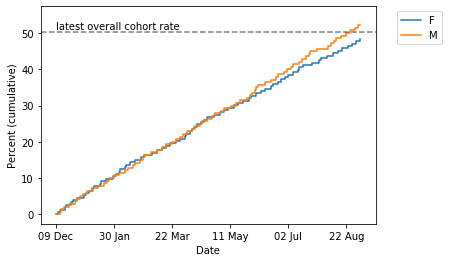

### COVID vaccinations among **80+** population by **ageband 5yr**

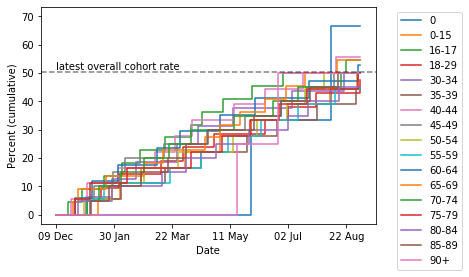

### COVID vaccinations among **80+** population by **ethnicity 6 groups**

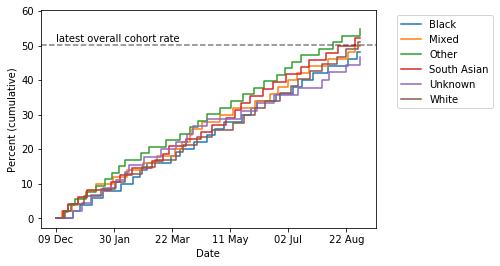

### COVID vaccinations among **80+** population by **imd categories**

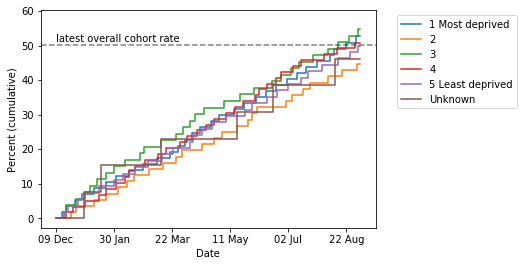

### COVID vaccinations among **80+** population by **bmi**

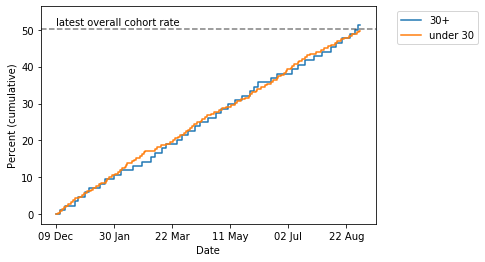

### COVID vaccinations among **80+** population by **dialysis**

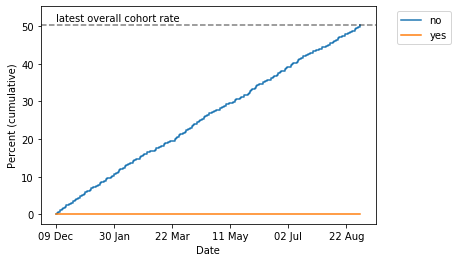

### COVID vaccinations among **80+** population by **dementia**

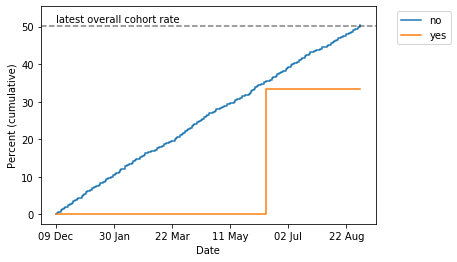

### COVID vaccinations among **80+** population by **psychosis schiz bipolar**

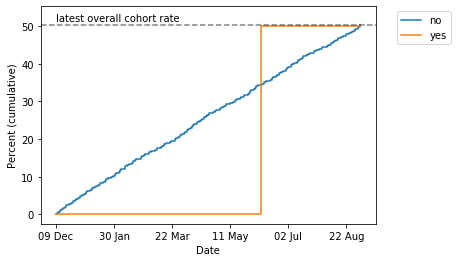

### COVID vaccinations among **80+** population by **LD**

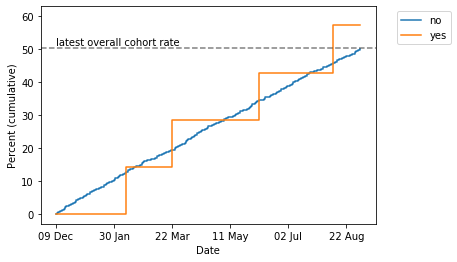

### COVID vaccinations among **80+** population by **ssri**

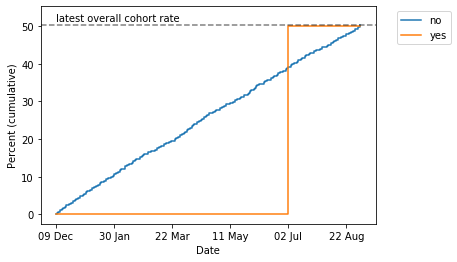

## 
 ## COVID vaccination rollout among **70-79** population up to 03 Sep 2021

### COVID vaccinations among **70-79** population by **sex**

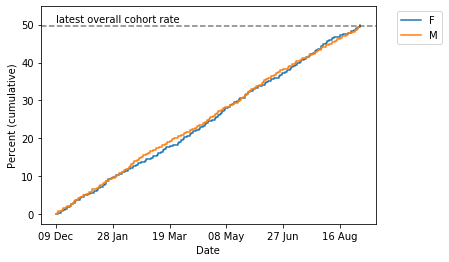

### COVID vaccinations among **70-79** population by **ageband 5yr**

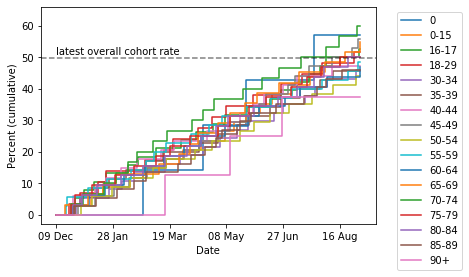

### COVID vaccinations among **70-79** population by **ethnicity 6 groups**

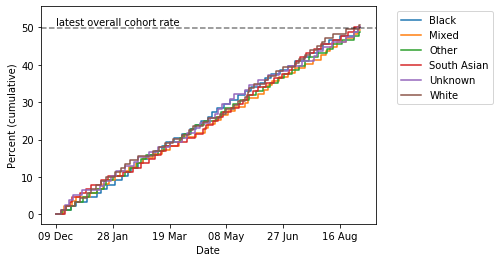

### COVID vaccinations among **70-79** population by **imd categories**

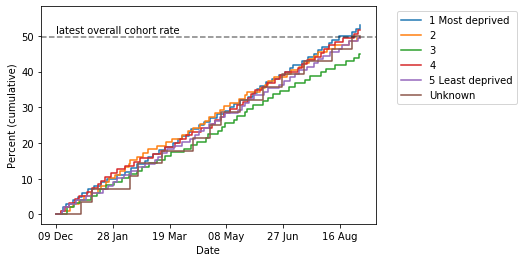

### COVID vaccinations among **70-79** population by **bmi**

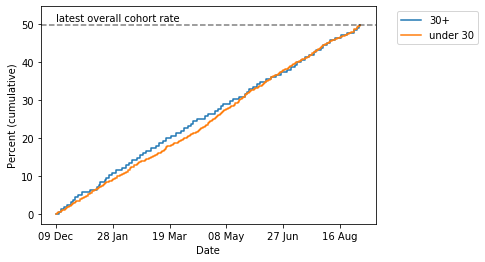

### COVID vaccinations among **70-79** population by **dialysis**

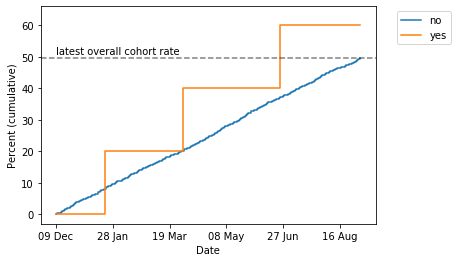

### COVID vaccinations among **70-79** population by **dementia**

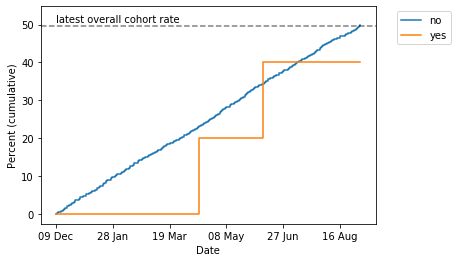

### COVID vaccinations among **70-79** population by **psychosis schiz bipolar**

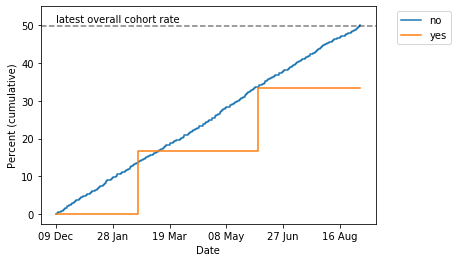

### COVID vaccinations among **70-79** population by **LD**

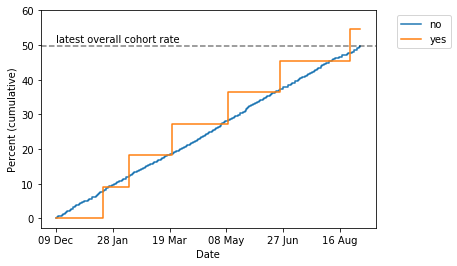

### COVID vaccinations among **70-79** population by **ssri**

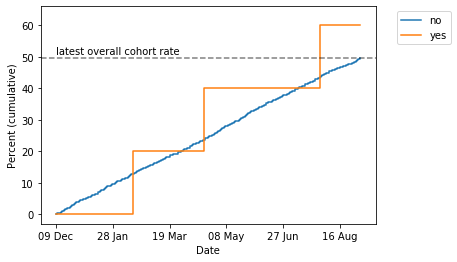

## 
 ## COVID vaccination rollout among **65-69** population up to 03 Sep 2021

### COVID vaccinations among **65-69** population by **sex**

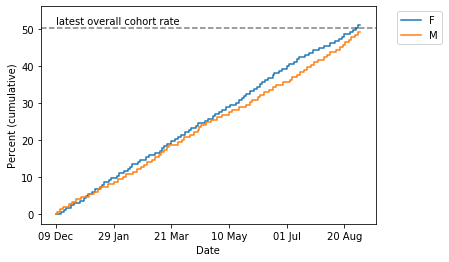

### COVID vaccinations among **65-69** population by **ethnicity 6 groups**

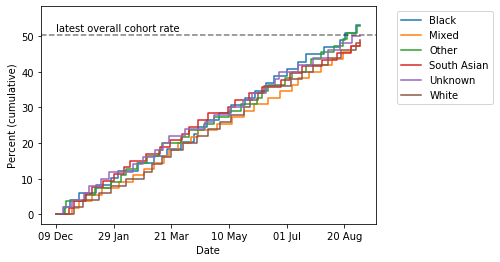

### COVID vaccinations among **65-69** population by **imd categories**

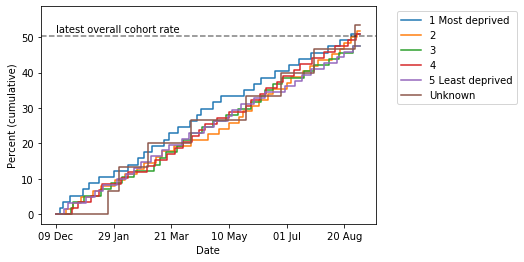

### COVID vaccinations among **65-69** population by **bmi**

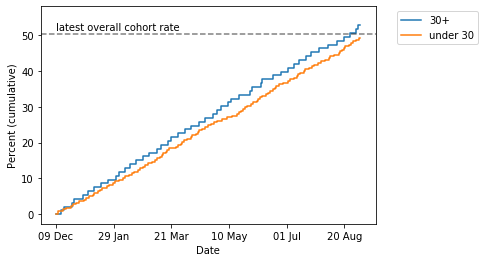

### COVID vaccinations among **65-69** population by **dementia**

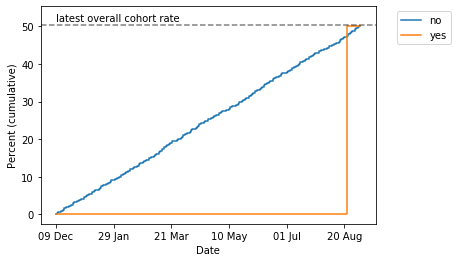

### COVID vaccinations among **65-69** population by **psychosis schiz bipolar**

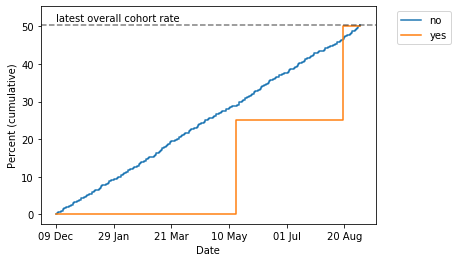

### COVID vaccinations among **65-69** population by **LD**

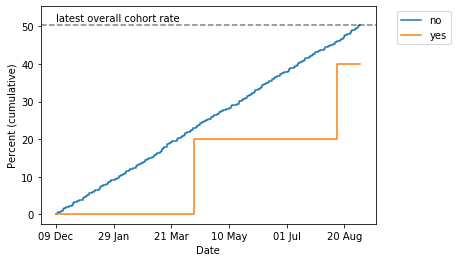

### COVID vaccinations among **65-69** population by **ssri**

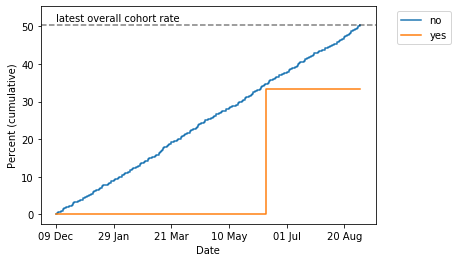

## 
 ## COVID vaccination rollout among **shielding (aged 16-69)** population up to 03 Sep 2021

### COVID vaccinations among **shielding (aged 16-69)** population by **newly shielded since feb 15**

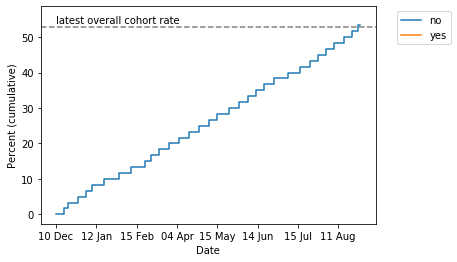

### COVID vaccinations among **shielding (aged 16-69)** population by **sex**

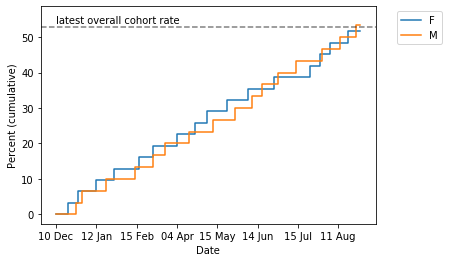

### COVID vaccinations among **shielding (aged 16-69)** population by **ageband**

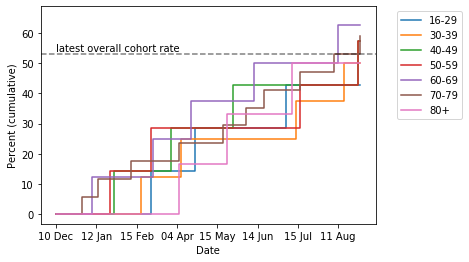

### COVID vaccinations among **shielding (aged 16-69)** population by **ethnicity 6 groups**

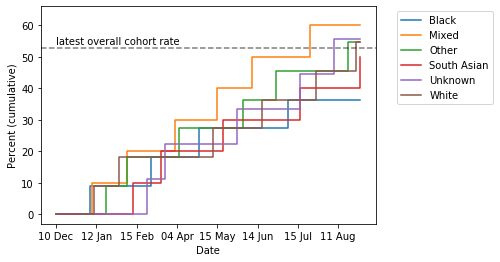

### COVID vaccinations among **shielding (aged 16-69)** population by **imd categories**

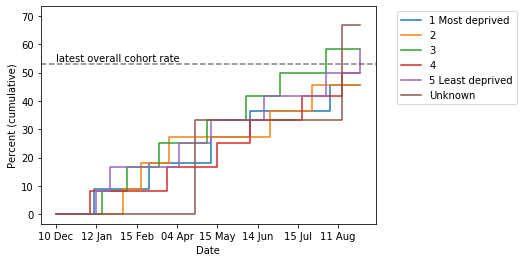

### COVID vaccinations among **shielding (aged 16-69)** population by **LD**

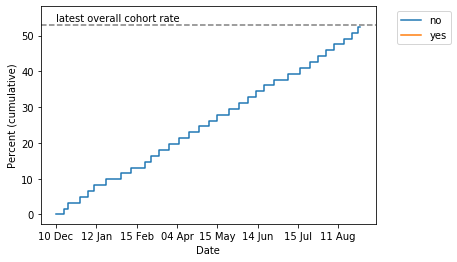

## 
 ## COVID vaccination rollout among **60-64** population up to 03 Sep 2021

### COVID vaccinations among **60-64** population by **sex**

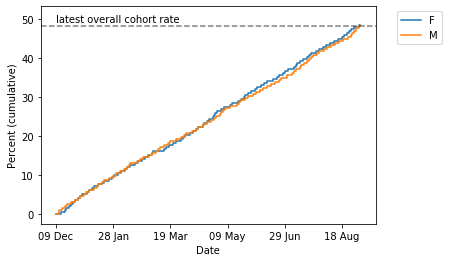

### COVID vaccinations among **60-64** population by **ethnicity 6 groups**

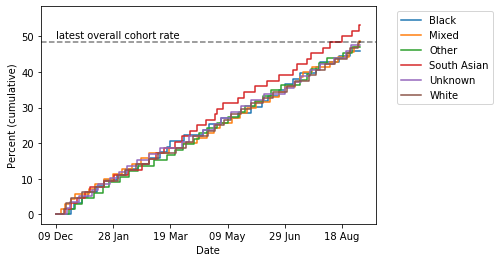

### COVID vaccinations among **60-64** population by **imd categories**

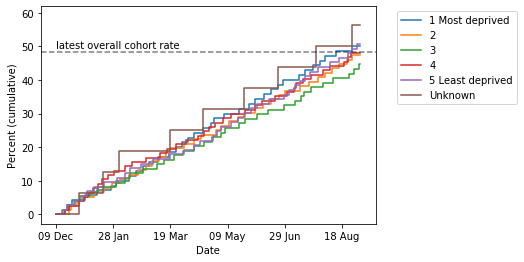

### COVID vaccinations among **60-64** population by **bmi**

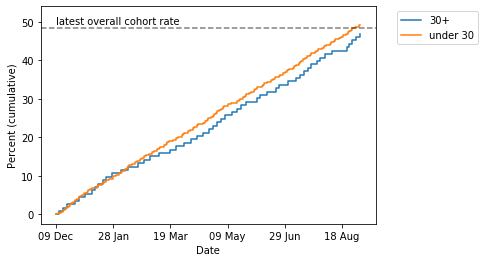

### COVID vaccinations among **60-64** population by **dementia**

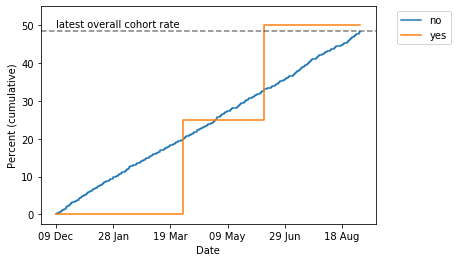

### COVID vaccinations among **60-64** population by **psychosis schiz bipolar**

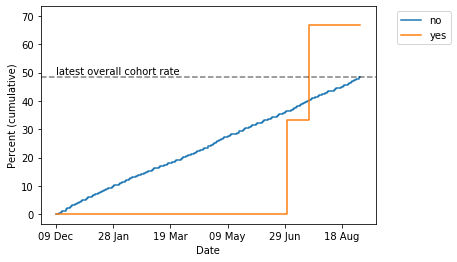

### COVID vaccinations among **60-64** population by **ssri**

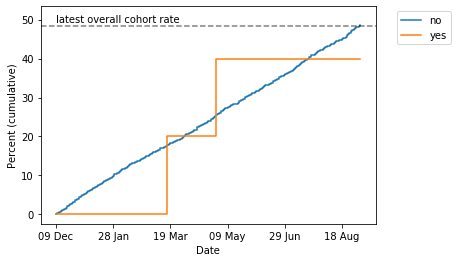

## 
 ## COVID vaccination rollout among **55-59** population up to 03 Sep 2021

### COVID vaccinations among **55-59** population by **sex**

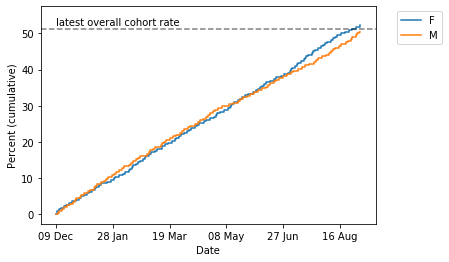

### COVID vaccinations among **55-59** population by **ethnicity 6 groups**

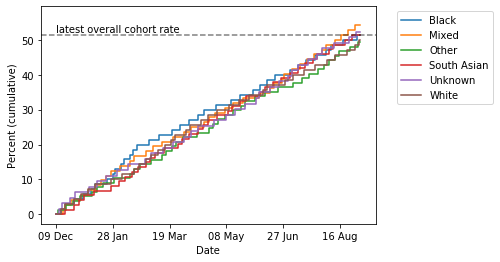

### COVID vaccinations among **55-59** population by **imd categories**

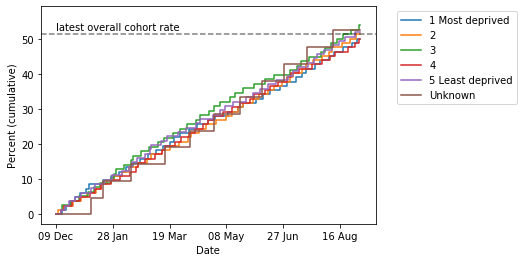

### COVID vaccinations among **55-59** population by **bmi**

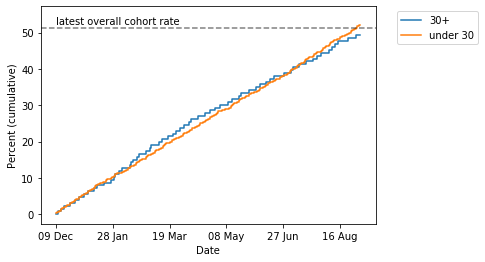

### COVID vaccinations among **55-59** population by **psychosis schiz bipolar**

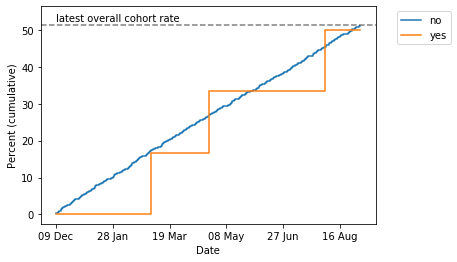

### COVID vaccinations among **55-59** population by **ssri**

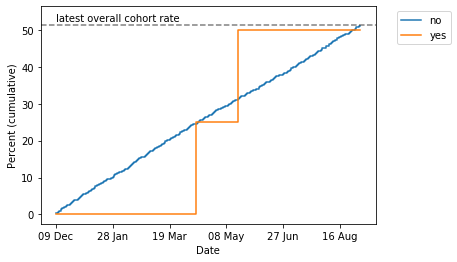

## 
 ## COVID vaccination rollout among **50-54** population up to 03 Sep 2021

### COVID vaccinations among **50-54** population by **sex**

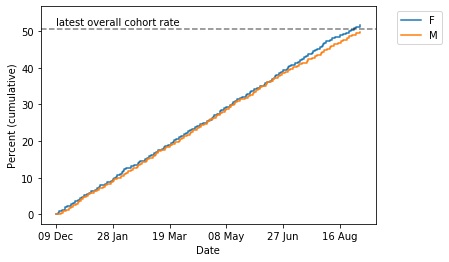

### COVID vaccinations among **50-54** population by **ethnicity 6 groups**

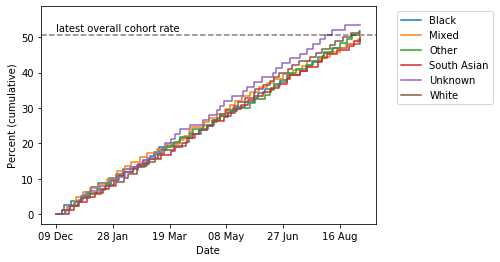

### COVID vaccinations among **50-54** population by **imd categories**

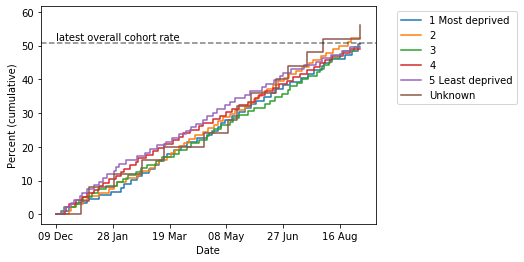

### COVID vaccinations among **50-54** population by **bmi**

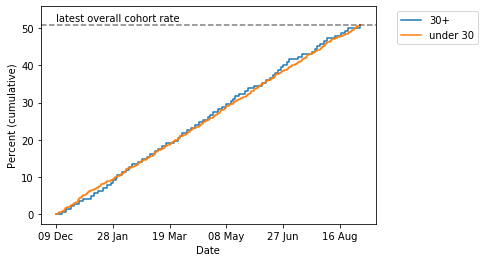

### COVID vaccinations among **50-54** population by **psychosis schiz bipolar**

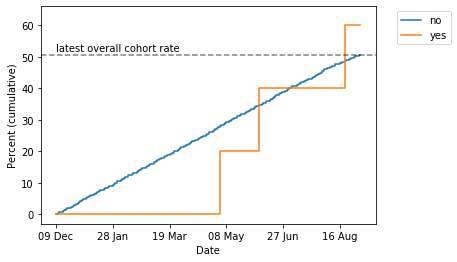

### COVID vaccinations among **50-54** population by **ssri**

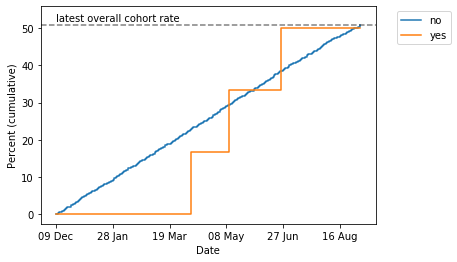

## 
 ## COVID vaccination rollout among **40-49** population up to 03 Sep 2021

### COVID vaccinations among **40-49** population by **sex**

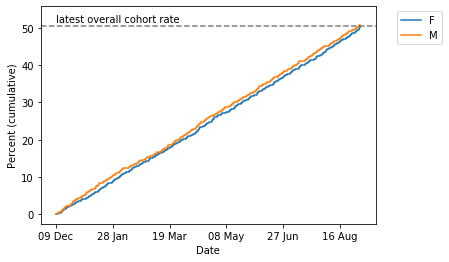

### COVID vaccinations among **40-49** population by **ethnicity 6 groups**

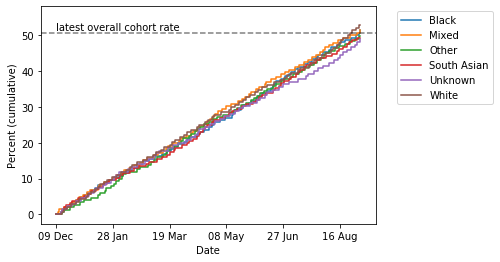

### COVID vaccinations among **40-49** population by **imd categories**

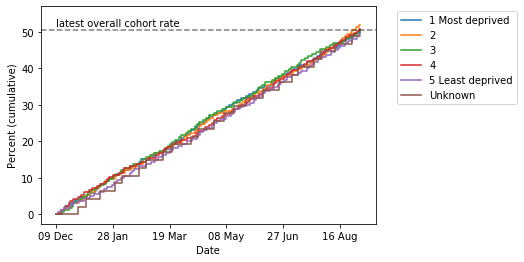

## 
 ## COVID vaccination rollout among **30-39** population up to 03 Sep 2021

### COVID vaccinations among **30-39** population by **sex**

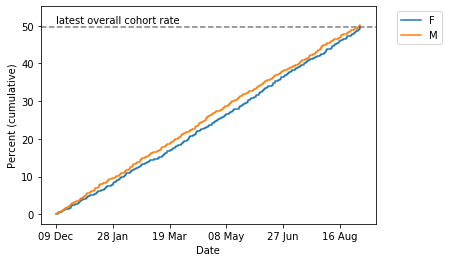

### COVID vaccinations among **30-39** population by **ethnicity 6 groups**

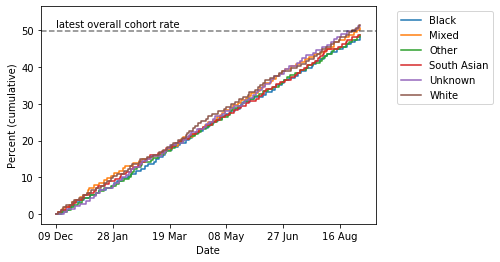

### COVID vaccinations among **30-39** population by **imd categories**

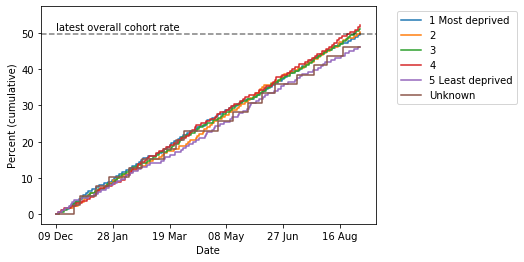

## 
 ## COVID vaccination rollout among **18-29** population up to 03 Sep 2021

### COVID vaccinations among **18-29** population by **sex**

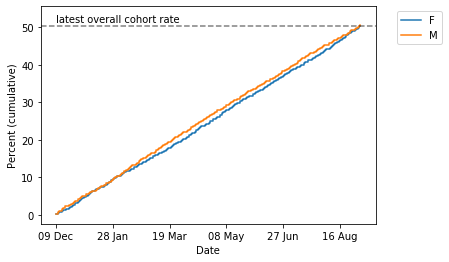

### COVID vaccinations among **18-29** population by **ethnicity 6 groups**

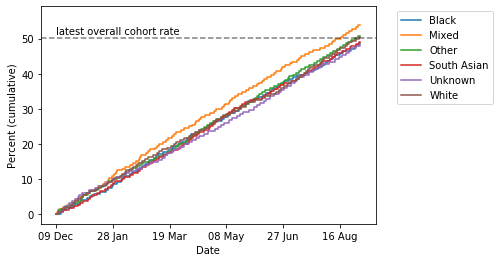

### COVID vaccinations among **18-29** population by **imd categories**

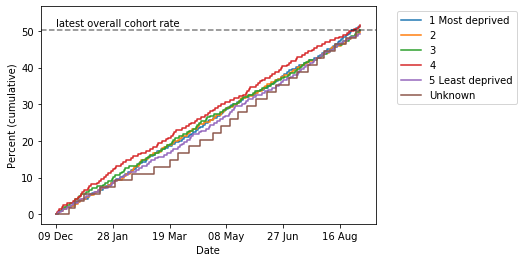

In [26]:
plot_dem_charts(summ_stat_results, df_dict_cum,  formatted_latest_date, pop_subgroups=["80+", "70-79", "65-69","shielding (aged 16-69)", "60-64", "55-59", "50-54", "40-49", "30-39", "18-29"], groups_dict=features_dict,
                groups_to_exclude=["ethnicity_16_groups", "current_copd", "chronic_cardiac_disease", "dmards", "chemo_or_radio", "lung_cancer", "cancer_excl_lung_and_haem", "haematological_cancer"],
                savepath=savepath, savepath_figure_csvs=savepath_figure_csvs, suffix=suffix)

## Completeness of ethnicity recording

In [27]:
from data_quality import *

ethnicity_completeness(df=df, groups_of_interest=population_subgroups)


Total **80+** population with ethnicity recorded 1,736 (84.6%)

Total **70-79** population with ethnicity recorded 3,087 (85.0%)

Total **care home** population with ethnicity recorded 1,162 (85.1%)

Total **shielding (aged 16-69)** population with ethnicity recorded 371 (86.9%)

Total **65-69** population with ethnicity recorded 1,834 (84.2%)

Total **LD (aged 16-64)** population with ethnicity recorded 665 (81.9%)

Total **60-64** population with ethnicity recorded 2,289 (84.7%)

Total **55-59** population with ethnicity recorded 2,541 (85.2%)

Total **50-54** population with ethnicity recorded 2,905 (84.5%)

Total **40-49** population with ethnicity recorded 5,215 (84.7%)

Total **30-39** population with ethnicity recorded 5,404 (84.7%)

Total **18-29** population with ethnicity recorded 6,328 (84.9%)

Total **16-17** population with ethnicity recorded 8,939 (85.8%)

# Second doses

In [28]:
# only count second doses where the first dose was given at least 14 weeks ago 
# to allow comparison of the first dose situation 14w ago with the second dose situation now
# otherwise bias could be introduced from any second doses given early in certain subgroups

date_14w = pd.to_datetime(df["covid_vacc_date"]).max() - timedelta(weeks=14)
date_14w = str(date_14w)[:10]

df_s = df.copy()
# replace any second doses not yet "due" with "0"
df_s.loc[(pd.to_datetime(df_s["covid_vacc_date"]) >= date_14w), "covid_vacc_second_dose_date"] = 0

# also ensure that first dose was dated after the start of the campaign, otherwise date is likely incorrect 
# and due date for second dose cannot be calculated accurately
# this also excludes any second doses where first dose date = 0 (this should affect dummy data only!)
df_s.loc[(pd.to_datetime(df_s["covid_vacc_date"]) <= "2020-12-07"), "covid_vacc_second_dose_date"] = 0

formatted_date_14w = datetime.strptime(date_14w, "%Y-%m-%d").strftime("%d %b %Y")
with open(os.path.join(savepath["text"], f"latest_date_of_first_dose_for_due_second_doses.txt"), "w") as text_file:
        text_file.write(formatted_date_14w)
        
display(Markdown(formatted_date_14w))

28 May 2021

In [29]:
# add "brand of first dose" to list of features to break down by
import copy
features_dict_2 = copy.deepcopy(features_dict)

for k in features_dict_2:
    ls = list(features_dict_2[k])
    ls.append("brand_of_first_dose") 
    features_dict_2[k] = ls

In [30]:

df_dict_cum_second_dose = cumulative_sums(df_s, groups_of_interest=population_subgroups, features_dict=features_dict_2, 
                                          latest_date=latest_date, reference_column_name="covid_vacc_second_dose_date")

In [31]:
second_dose_summarised_data_dict = summarise_data_by_group(df_dict_cum_second_dose, latest_date=latest_date, groups=groups)

In [32]:
create_detailed_summary_uptake(second_dose_summarised_data_dict, formatted_latest_date, 
                               groups=groups,
                               savepath=savepath, vaccine_type="second_dose")

## 

## COVID vaccination rollout (second dose) among **80+** population up to 03 Sep 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                     207   
sex                       F                                           119   
                          M                                            91   
ageband_5yr               0                                             0   
                          0-15                                          7   
                          16-17                                        21   
                          18-29                                        14   
                          30-34                                        14   
                          35-39                                        14   
                          40-44                                        14   
                          45-49                                        14   
                          50-54                                        14   
                          55-59                                         7   
                          60-64                                        14   
                          65-69                                        14   
                          70-74                                        14   
                          75-79                                        14   
                          80-84                                        14   
                          85-89                                        14   
                          90+                                           0   
ethnicity_6_groups        Black                                        35   
                          Mixed                                        28   
                          Other                                        42   
                          South Asian                                  42   
                          Unknown                                      35   
                          White                                        28   
ethnicity_16_groups        African                                      7   
                           Bangladeshi or British Bangladeshi          14   
                           Caribbean                                    7   
                           Chinese                                     14   
                           Other                                       14   
                           Other Asian                                 14   
                          British or Mixed British                      0   
                          Indian or British Indian                      7   
                          Irish                                         7   
                          Other Black                                  14   
                          Other White                                   7   
                          Other mixed                                  14   
                          Pakistani or British Pakistani                7   
                          Unknown                                      35   
                          White + Asian                                14   
                          White + Black African                         7   
                          White + Black Caribbean                       7   
imd_categories            1 Most deprived                              42   
                          2                                            35   
                          3                                            42   
                          4                                            42   
                          5 Least deprived                             42   
                          Unknown                                       7   
bmi                       30+                                          56   
                          under 30                         

## 

## COVID vaccination rollout (second dose) among **70-79** population up to 03 Sep 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                     358   
sex                       F                                           168   
                          M                                           189   
ageband_5yr               0                                             7   
                          0-15                                         35   
                          16-17                                        21   
                          18-29                                        21   
                          30-34                                        21   
                          35-39                                        21   
                          40-44                                        28   
                          45-49                                        21   
                          50-54                                        14   
                          55-59                                        28   
                          60-64                                        14   
                          65-69                                        21   
                          70-74                                        35   
                          75-79                                        28   
                          80-84                                        28   
                          85-89                                        21   
                          90+                                           0   
ethnicity_6_groups        Black                                        63   
                          Mixed                                        56   
                          Other                                        63   
                          South Asian                                  56   
                          Unknown                                      56   
                          White                                        56   
ethnicity_16_groups        African                                     21   
                           Bangladeshi or British Bangladeshi          21   
                           Caribbean                                   21   
                           Chinese                                     28   
                           Other                                       14   
                           Other Asian                                 21   
                          British or Mixed British                     28   
                          Indian or British Indian                     21   
                          Irish                                        14   
                          Other Black                                  14   
                          Other White                                  21   
                          Other mixed                                  14   
                          Pakistani or British Pakistani               14   
                          Unknown                                      49   
                          White + Asian                                35   
                          White + Black African                        21   
                          White + Black Caribbean                      14   
imd_categories            1 Most deprived                              70   
                          2                                            70   
                          3                                            49   
                          4                                            70   
                          5 Least deprived                             84   
                          Unknown                                      14   
bmi                       30+                                         112   
                          under 30                         

## 

## COVID vaccination rollout (second dose) among **care home** population up to 03 Sep 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category            group                                     
overall             overall             120      8.8   1365   
sex                 F                    70      9.7    721   
                    M                    49      7.6    644   
ageband_5yr         0                     0      0.0     28   
                    0-15                  7      9.1     77   
                    16-17                14     14.3     98   
                    18-29                 7      8.3     84   
                    30-34                 7      9.1     77   
                    35-39                 7      8.3     84   
                    40-44                 7      5.9    119   
                    45-49                 0      0.0     77   
                    50-54                 0      0.0     70   
                    55-59                 0      0.0     77   
                    60-64                 7      7.7     91   
                    65-69                 7      7.7     91   
                    70-74                 7      6.7    105   
                    75-79                 0      0.0     84   
                    80-84                14     14.3     98   
                    85-89                 7      7.7     91   
                    90+                   0      0.0     21   
ethnicity_6_groups  Black                28     11.8    238   
                    Mixed                21      9.1    231   
                    Other                14      6.1    231   
                    South Asian          14      6.5    217   
                    Unknown              21     10.3    203   
                    White                28     11.4    245   
dementia            no                  119      8.8   1351   
brand_of_first_dose Unknown             119     18.3    651   

                                vaccinated 7d previous (percent)  \
category            group                                          
overall             overall                                  8.4   
sex                 F                                        9.7   
                    M                                        7.6   
ageband_5yr         0                                          0   
                    0-15                                     9.1   
                    16-17                                   14.3   
                    18-29                                    8.3   
                    30-34                                    9.1   
                    35-39                                    8.3   
                    40-44                                    5.9   
                    45-49                                      0   
                    50-54                                      0   
                    55-59                                      0   
                    60-64                                      0   
                    65-69                                    7.7   
                    70-74                                    6.7   
                    75-79                                      0   
                    80-84                                   14.3   
                    85-89                                    7.7   
                    90+                                        0   
ethnicity_6_groups  Black                                   11.8   
                    Mixed                                    9.1   
                    Other                                    6.1   
                    South Asian                              6.5   
                    Unknown                                  6.9   
                    White                                    8.6   
dementia            no                                       8.3   
brand_of_first_dose Unknown                                 17.2   

                                Uptake over last 7d (percent)  \
category            group           

## 

## COVID vaccination rollout (second dose) among **shielding (aged 16-69)** population up to 03 Sep 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category                    group                                          
overall                     overall                   35      8.2    427   
newly_shielded_since_feb_15 no                        35      8.3    420   
sex                         F                         21      9.7    217   
                            M                         14      6.7    210   
ageband                     16-29                      0      0.0     49   
                            30-39                      0      0.0     56   
                            40-49                      0      0.0     49   
                            50-59                      0      0.0     49   
                            60-69                      7     12.5     56   
                            70-79                      7      5.9    119   
                            80+                        0      0.0     42   
ethnicity_6_groups          Black                      0      0.0     77   
                            Mixed                      7     10.0     70   
                            Other                      0      0.0     77   
                            South Asian                0      0.0     70   
                            Unknown                    0      0.0     63   
                            White                      7      9.1     77   
imd_categories              1 Most deprived            0      0.0     77   
                            2                          0      0.0     77   
                            3                          7      8.3     84   
                            4                          0      0.0     84   
                            5 Least deprived          14     16.7     84   
                            Unknown                    0      0.0     21   
LD                          no                        35      8.2    427   
                            yes                        0      0.0      0   
brand_of_first_dose         Pfizer                     0      0.0      0   
                            Unknown                   35     15.6    224   

                                             vaccinated 7d previous (percent)  \
category                    group                                               
overall                     overall                                       8.2   
newly_shielded_since_feb_15 no                                            8.3   
sex                         F                                             9.7   
                            M                                             6.7   
ageband                     16-29                                           0   
                            30-39                                           0   
                            40-49                                           0   
                            50-59                                           0   
                            60-69                                        12.5   
                            70-79                                         5.9   
                            80+                                             0   
ethnicity_6_groups          Black                                           0   
                            Mixed                                          10   
                            Other                                           0   
                            South Asian                                     0   
                            Unknown                                         0   
                            White                                         9.1   
imd_categories              1 Most deprived                                 0   
                            2                                               0   
                            3                                             8.3   
                            4                              

## 

## COVID vaccination rollout (second dose) among **65-69** population up to 03 Sep 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                     201   
sex                       F                                           112   
                          M                                            91   
ethnicity_6_groups        Black                                        28   
                          Mixed                                        35   
                          Other                                        35   
                          South Asian                                  42   
                          Unknown                                      28   
                          White                                        35   
ethnicity_16_groups        African                                     14   
                           Bangladeshi or British Bangladeshi          14   
                           Caribbean                                   14   
                           Chinese                                      7   
                           Other                                       14   
                           Other Asian                                  7   
                          British or Mixed British                      7   
                          Indian or British Indian                     14   
                          Irish                                        14   
                          Other Black                                   7   
                          Other White                                   7   
                          Other mixed                                   7   
                          Pakistani or British Pakistani               14   
                          Unknown                                      28   
                          White + Asian                                14   
                          White + Black African                         7   
                          White + Black Caribbean                      14   
imd_categories            1 Most deprived                              42   
                          2                                            42   
                          3                                            35   
                          4                                            35   
                          5 Least deprived                             42   
                          Unknown                                       7   
bmi                       30+                                          56   
                          under 30                                    140   
chronic_cardiac_disease   no                                          196   
                          yes                                           0   
current_copd              no                                          196   
                          yes                                           0   
dmards                    no                                          203   
                          yes                                           0   
dementia                  no                                          203   
                          yes                                           0   
psychosis_schiz_bipolar   no                                          196   
                          yes                                           0   
LD                        no                                          196   
                          yes                                           0   
ssri                      no                                          196   
                          yes                                           0   
chemo_or_radio            no                                          196   
                          yes                                           0   
lung_cancer               no                               

## 

## COVID vaccination rollout (second dose) among **LD (aged 16-64)** population up to 03 Sep 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category            group                                     
overall             overall              83     10.2    812   
sex                 F                    42      9.8    427   
                    M                    42     10.7    392   
ageband_5yr         0-15                  0      0.0     56   
                    16-17                 0      0.0     49   
                    18-29                 7     12.5     56   
                    30-34                 0      0.0     49   
                    35-39                 0      0.0     49   
                    40-44                 0      0.0     49   
                    45-49                14     25.0     56   
                    50-54                 7     11.1     63   
                    55-59                 0      0.0     49   
                    60-64                 0      0.0     49   
                    65-69                 0      0.0     56   
                    70-74                 0      0.0     49   
                    75-79                 0      0.0     63   
                    80-84                 7     14.3     49   
                    85-89                 0      0.0     70   
ethnicity_6_groups  Black                 7      5.6    126   
                    Mixed                14      9.5    147   
                    Other                21     15.0    140   
                    South Asian          14     10.0    140   
                    Unknown              21     14.3    147   
                    White                 7      6.2    112   
brand_of_first_dose Unknown              84     21.1    399   

                                vaccinated 7d previous (percent)  \
category            group                                          
overall             overall                                   10   
sex                 F                                        9.8   
                    M                                        8.9   
ageband_5yr         0-15                                       0   
                    16-17                                      0   
                    18-29                                   12.5   
                    30-34                                      0   
                    35-39                                      0   
                    40-44                                      0   
                    45-49                                     25   
                    50-54                                   11.1   
                    55-59                                      0   
                    60-64                                      0   
                    65-69                                      0   
                    70-74                                      0   
                    75-79                                      0   
                    80-84                                   14.3   
                    85-89                                      0   
ethnicity_6_groups  Black                                    5.6   
                    Mixed                                    9.5   
                    Other                                     15   
                    South Asian                               10   
                    Unknown                                  9.5   
                    White                                    6.2   
brand_of_first_dose Unknown                                 21.1   

                                Uptake over last 7d (percent)  \
category            group                                       
overall             overall                               0.2   
sex                 F                                       0   
                    M                                     1.8   
ageband_5yr         0-15                                    0   
                    16-17                                   0   
                    18-29              

## 

## COVID vaccination rollout (second dose) among **60-64** population up to 03 Sep 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                     230   
sex                       F                                           105   
                          M                                           126   
ethnicity_6_groups        Black                                        42   
                          Mixed                                        35   
                          Other                                        49   
                          South Asian                                  49   
                          Unknown                                      35   
                          White                                        35   
ethnicity_16_groups        African                                     14   
                           Bangladeshi or British Bangladeshi          14   
                           Caribbean                                   14   
                           Chinese                                      7   
                           Other                                        7   
                           Other Asian                                 21   
                          British or Mixed British                      7   
                          Indian or British Indian                     14   
                          Irish                                        14   
                          Other Black                                  14   
                          Other White                                  14   
                          Other mixed                                   7   
                          Pakistani or British Pakistani               14   
                          Unknown                                      28   
                          White + Asian                                14   
                          White + Black African                        14   
                          White + Black Caribbean                      21   
imd_categories            1 Most deprived                              42   
                          2                                            56   
                          3                                            49   
                          4                                            35   
                          5 Least deprived                             42   
                          Unknown                                       7   
bmi                       30+                                          77   
                          under 30                                    154   
chronic_cardiac_disease   no                                          231   
                          yes                                           0   
current_copd              no                                          231   
                          yes                                           0   
dmards                    no                                          231   
                          yes                                           0   
dementia                  no                                          231   
                          yes                                           0   
psychosis_schiz_bipolar   no                                          231   
                          yes                                           0   
ssri                      no                                          231   
                          yes                                           0   
chemo_or_radio            no                                          224   
                          yes                                           0   
lung_cancer               no                                          231   
cancer_excl_lung_and_haem no                                          224   
                          yes                              

## 

## COVID vaccination rollout (second dose) among **55-59** population up to 03 Sep 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                     303   
sex                     F                                           154   
                        M                                           147   
ethnicity_6_groups      Black                                        49   
                        Mixed                                        49   
                        Other                                        56   
                        South Asian                                  49   
                        Unknown                                      42   
                        White                                        56   
ethnicity_16_groups      African                                     14   
                         Bangladeshi or British Bangladeshi          21   
                         Caribbean                                   14   
                         Chinese                                     14   
                         Other                                       14   
                         Other Asian                                 21   
                        British or Mixed British                     14   
                        Indian or British Indian                     21   
                        Irish                                        14   
                        Other Black                                   7   
                        Other White                                  21   
                        Other mixed                                  14   
                        Pakistani or British Pakistani               14   
                        Unknown                                      42   
                        White + Asian                                14   
                        White + Black African                        14   
                        White + Black Caribbean                      14   
imd_categories          1 Most deprived                              56   
                        2                                            63   
                        3                                            63   
                        4                                            56   
                        5 Least deprived                             49   
                        Unknown                                      21   
bmi                     30+                                          98   
                        under 30                                    210   
chronic_cardiac_disease no                                          301   
                        yes                                           0   
current_copd            no                                          301   
                        yes                                           0   
dmards                  no                                          301   
                        yes                                           0   
psychosis_schiz_bipolar no                                          294   
                        yes                                           0   
ssri                    no                                          301   
                        yes                                           0   
brand_of_first_dose     Unknown                                     301   

                                                             percent  total  \
category                group                                                 
overall                 overall                                 10.2   2982   
sex                     F                                        9.9   1554   
                        M                                       10.3   1428   
ethnicity_6_groups      Black                                   10.0    490   
                        Mixed                                

## 

## COVID vaccination rollout (second dose) among **50-54** population up to 03 Sep 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                     352   
sex                     F                                           175   
                        M                                           175   
ethnicity_6_groups      Black                                        49   
                        Mixed                                        63   
                        Other                                        63   
                        South Asian                                  56   
                        Unknown                                      63   
                        White                                        56   
ethnicity_16_groups      African                                      7   
                         Bangladeshi or British Bangladeshi          21   
                         Caribbean                                   21   
                         Chinese                                     28   
                         Other                                       21   
                         Other Asian                                 14   
                        British or Mixed British                     14   
                        Indian or British Indian                     21   
                        Irish                                        14   
                        Other Black                                  21   
                        Other White                                  21   
                        Other mixed                                  21   
                        Pakistani or British Pakistani               21   
                        Unknown                                      49   
                        White + Asian                                21   
                        White + Black African                        14   
                        White + Black Caribbean                      28   
imd_categories          1 Most deprived                              56   
                        2                                            70   
                        3                                            70   
                        4                                            77   
                        5 Least deprived                             63   
                        Unknown                                      14   
bmi                     30+                                          98   
                        under 30                                    252   
chronic_cardiac_disease no                                          350   
                        yes                                           0   
current_copd            no                                          350   
                        yes                                           0   
dmards                  no                                          350   
                        yes                                           0   
psychosis_schiz_bipolar no                                          350   
                        yes                                           0   
ssri                    no                                          350   
                        yes                                           0   
brand_of_first_dose     Unknown                                     350   

                                                             percent  total  \
category                group                                                 
overall                 overall                                 10.2   3437   
sex                     F                                        9.9   1764   
                        M                                       10.5   1673   
ethnicity_6_groups      Black                                    8.9    553   
                        Mixed                                

## 

## COVID vaccination rollout (second dose) among **40-49** population up to 03 Sep 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  \
category            group                                                      
overall             overall                                     569      9.2   
sex                 F                                           294      9.2   
                    M                                           273      9.2   
ethnicity_6_groups  Black                                        98      9.5   
                    Mixed                                        91      8.9   
                    Other                                       105      9.9   
                    South Asian                                  98      9.0   
                    Unknown                                      84      8.9   
                    White                                        91      9.0   
ethnicity_16_groups  African                                     35     10.4   
                     Bangladeshi or British Bangladeshi          21      6.7   
                     Caribbean                                   28      8.2   
                     Chinese                                     21      6.5   
                     Other                                       35      9.6   
                     Other Asian                                 28      9.5   
                    British or Mixed British                     28      8.3   
                    Indian or British Indian                     28      8.7   
                    Irish                                        28      8.5   
                    Other Black                                  35     10.0   
                    Other White                                  28      9.1   
                    Other mixed                                  35     11.6   
                    Pakistani or British Pakistani               42     13.0   
                    Unknown                                      84      9.2   
                    White + Asian                                35     10.4   
                    White + Black African                        28      8.5   
                    White + Black Caribbean                      35     10.4   
imd_categories      1 Most deprived                             126     10.4   
                    2                                            98      8.4   
                    3                                           105      9.0   
                    4                                            98      8.4   
                    5 Least deprived                            105      9.4   
                    Unknown                                      28      8.5   
brand_of_first_dose Unknown                                     567     18.2   

                                                         total  \
category            group                                        
overall             overall                               6160   
sex                 F                                     3206   
                    M                                     2954   
ethnicity_6_groups  Black                                 1036   
                    Mixed                                 1022   
                    Other                                 1057   
                    South Asian                           1092   
                    Unknown                                945   
                    White                                 1008   
ethnicity_16_groups  African                               336   
                     Bangladeshi or British Bangladeshi    315   
                     Caribbean                             343   
                     Chinese                               322   
                     Other                                 364   
                     Other Asian                           294   
                    British or Mixed British               336   
                    Indian or British Indian               322   
  

## 

## COVID vaccination rollout (second dose) among **30-39** population up to 03 Sep 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  \
category            group                                                      
overall             overall                                     610      9.6   
sex                 F                                           294      9.1   
                    M                                           315     10.0   
ethnicity_6_groups  Black                                        98      9.1   
                    Mixed                                        98      9.2   
                    Other                                       105      9.6   
                    South Asian                                 105      9.6   
                    Unknown                                      91      9.4   
                    White                                       112     10.4   
ethnicity_16_groups  African                                     35     10.9   
                     Bangladeshi or British Bangladeshi          21      6.4   
                     Caribbean                                   28      8.3   
                     Chinese                                     28      8.7   
                     Other                                       35      9.6   
                     Other Asian                                 49     13.2   
                    British or Mixed British                     35     10.2   
                    Indian or British Indian                     42     13.6   
                    Irish                                        21      6.0   
                    Other Black                                  28      7.7   
                    Other White                                  28      8.9   
                    Other mixed                                  35      9.8   
                    Pakistani or British Pakistani               35     10.9   
                    Unknown                                      91      9.7   
                    White + Asian                                21      6.1   
                    White + Black African                        42     11.3   
                    White + Black Caribbean                      35     10.9   
imd_categories      1 Most deprived                             126      9.6   
                    2                                           119      9.9   
                    3                                           105      8.8   
                    4                                           133     11.4   
                    5 Least deprived                            105      8.5   
                    Unknown                                      21      7.7   
brand_of_first_dose Pfizer                                        0      0.0   
                    Unknown                                     609     19.2   

                                                         total  \
category            group                                        
overall             overall                               6377   
sex                 F                                     3220   
                    M                                     3157   
ethnicity_6_groups  Black                                 1078   
                    Mixed                                 1064   
                    Other                                 1092   
                    South Asian                           1092   
                    Unknown                                973   
                    White                                 1078   
ethnicity_16_groups  African                               322   
                     Bangladeshi or British Bangladeshi    329   
                     Caribbean                             336   
                     Chinese                               322   
                     Other                                 364   
                     Other Asian                           371   
                    British or Mixed British          

## 

## COVID vaccination rollout (second dose) among **18-29** population up to 03 Sep 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  \
category            group                                                      
overall             overall                                     687      9.2   
sex                 F                                           329      8.7   
                    M                                           357      9.8   
ethnicity_6_groups  Black                                       112      9.1   
                    Mixed                                       147     11.4   
                    Other                                       119      9.4   
                    South Asian                                  98      7.8   
                    Unknown                                     105      9.3   
                    White                                       112      8.7   
ethnicity_16_groups  African                                     42      9.8   
                     Bangladeshi or British Bangladeshi          35      8.1   
                     Caribbean                                   35      9.4   
                     Chinese                                     42     10.2   
                     Other                                       42     10.3   
                     Other Asian                                 28      7.5   
                    British or Mixed British                     35      8.8   
                    Indian or British Indian                     35      9.3   
                    Irish                                        35      8.1   
                    Other Black                                  35      8.6   
                    Other White                                  35      9.3   
                    Other mixed                                  28      7.8   
                    Pakistani or British Pakistani               42     10.5   
                    Unknown                                     112      9.9   
                    White + Asian                                42     10.7   
                    White + Black African                        28      6.7   
                    White + Black Caribbean                      35      9.8   
imd_categories      1 Most deprived                             140      9.6   
                    2                                           126      8.5   
                    3                                           126      9.1   
                    4                                           147     10.7   
                    5 Least deprived                            126      9.1   
                    Unknown                                      28      7.4   
brand_of_first_dose Unknown                                     686     18.3   

                                                         total  \
category            group                                        
overall             overall                               7455   
sex                 F                                     3794   
                    M                                     3661   
ethnicity_6_groups  Black                                 1232   
                    Mixed                                 1288   
                    Other                                 1267   
                    South Asian                           1253   
                    Unknown                               1127   
                    White                                 1288   
ethnicity_16_groups  African                               427   
                     Bangladeshi or British Bangladeshi    434   
                     Caribbean                             371   
                     Chinese                               413   
                     Other                                 406   
                     Other Asian                           371   
                    British or Mixed British               399   
                    Indian or British Indian               378   
  

## 

## COVID vaccination rollout (second dose) among **16-17** population up to 03 Sep 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  \
category            group                                                      
overall             overall                                    1006      9.7   
sex                 F                                           525      9.9   
                    M                                           483      9.4   
ethnicity_6_groups  Black                                       196     10.9   
                    Mixed                                       168      9.4   
                    Other                                       168      9.6   
                    South Asian                                 161      8.9   
                    Unknown                                     147     10.0   
                    White                                       161      9.0   
ethnicity_16_groups  African                                     63     11.2   
                     Bangladeshi or British Bangladeshi          56     10.3   
                     Caribbean                                   49      9.0   
                     Chinese                                     42      8.0   
                     Other                                       56      9.8   
                     Other Asian                                 56     10.8   
                    British or Mixed British                     49      8.5   
                    Indian or British Indian                     56      9.8   
                    Irish                                        63     11.2   
                    Other Black                                  63     11.0   
                    Other White                                  49      9.1   
                    Other mixed                                  56     10.1   
                    Pakistani or British Pakistani               42      7.9   
                    Unknown                                     154      9.7   
                    White + Asian                                42      7.7   
                    White + Black African                        63     11.0   
                    White + Black Caribbean                      49      9.2   
imd_categories      1 Most deprived                             168      8.7   
                    2                                           210     10.8   
                    3                                           203     10.2   
                    4                                           182      9.1   
                    5 Least deprived                            196      9.6   
                    Unknown                                      42      8.5   
brand_of_first_dose Oxford-AZ                                     0      0.0   
                    Pfizer                                        0      0.0   
                    Unknown                                    1001     19.4   

                                                         total  \
category            group                                        
overall             overall                              10416   
sex                 F                                     5292   
                    M                                     5131   
ethnicity_6_groups  Black                                 1806   
                    Mixed                                 1792   
                    Other                                 1757   
                    South Asian                           1806   
                    Unknown                               1477   
                    White                                 1785   
ethnicity_16_groups  African                               560   
                     Bangladeshi or British Bangladeshi    546   
                     Caribbean                             546   
                     Chinese                               525   
                     Other                                 574   
                     Other Asian        

## For comparison look at first doses UP TO 14 WEEKS AGO


In [33]:
# latest date of 14 weeks ago is entered as the latest_date when calculating cumulative sums below.

# Seperately, we also ensure that first dose was dated after the start of the campaign, 
# to be consistent with the second doses due calculated above
df_14w = df.copy()
df_14w.loc[(pd.to_datetime(df_14w["covid_vacc_date"]) <= "2020-12-07"), "covid_vacc_date"] = 0


df_dict_cum_14w = cumulative_sums(
                                  df_14w, groups_of_interest=population_subgroups, features_dict=features_dict_2, 
                                  latest_date=date_14w
                                  )

summarised_data_dict_14w = summarise_data_by_group(
                                                   df_dict_cum_14w, 
                                                   latest_date=date_14w, 
                                                   groups=groups
                                                   )

create_detailed_summary_uptake(summarised_data_dict_14w, formatted_latest_date=date_14w, 
                               groups=groups,
                               savepath=savepath, vaccine_type="first_dose_14w_ago")

## 

## COVID vaccination rollout (first dose 14w ago) among **80+** population up to 2021-05-28

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                     666   
sex                       F                                           343   
                          M                                           322   
ageband_5yr               0                                             0   
                          0-15                                         35   
                          16-17                                        63   
                          18-29                                        42   
                          30-34                                        42   
                          35-39                                        35   
                          40-44                                        49   
                          45-49                                        49   
                          50-54                                        35   
                          55-59                                        35   
                          60-64                                        42   
                          65-69                                        56   
                          70-74                                        49   
                          75-79                                        42   
                          80-84                                        42   
                          85-89                                        42   
                          90+                                           7   
ethnicity_6_groups        Black                                       105   
                          Mixed                                       112   
                          Other                                       133   
                          South Asian                                 119   
                          Unknown                                      98   
                          White                                        98   
ethnicity_16_groups        African                                     42   
                           Bangladeshi or British Bangladeshi          35   
                           Caribbean                                   35   
                           Chinese                                     42   
                           Other                                       35   
                           Other Asian                                 35   
                          British or Mixed British                     28   
                          Indian or British Indian                     35   
                          Irish                                        28   
                          Other Black                                  35   
                          Other White                                  42   
                          Other mixed                                  35   
                          Pakistani or British Pakistani               42   
                          Unknown                                      98   
                          White + Asian                                42   
                          White + Black African                        35   
                          White + Black Caribbean                      28   
imd_categories            1 Most deprived                             133   
                          2                                           112   
                          3                                           133   
                          4                                           140   
                          5 Least deprived                            119   
                          Unknown                                      28   
bmi                       30+                                         196   
                          under 30                         

## 

## COVID vaccination rollout (first dose 14w ago) among **70-79** population up to 2021-05-28

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    1175   
sex                       F                                           588   
                          M                                           588   
ageband_5yr               0                                            21   
                          0-15                                         77   
                          16-17                                        91   
                          18-29                                        70   
                          30-34                                        77   
                          35-39                                        77   
                          40-44                                        77   
                          45-49                                        70   
                          50-54                                        63   
                          55-59                                        84   
                          60-64                                        70   
                          65-69                                        77   
                          70-74                                        84   
                          75-79                                        77   
                          80-84                                        70   
                          85-89                                        77   
                          90+                                          14   
ethnicity_6_groups        Black                                       203   
                          Mixed                                       189   
                          Other                                       196   
                          South Asian                                 196   
                          Unknown                                     189   
                          White                                       210   
ethnicity_16_groups        African                                     56   
                           Bangladeshi or British Bangladeshi          63   
                           Caribbean                                   63   
                           Chinese                                     77   
                           Other                                       56   
                           Other Asian                                 56   
                          British or Mixed British                     70   
                          Indian or British Indian                     63   
                          Irish                                        56   
                          Other Black                                  63   
                          Other White                                  56   
                          Other mixed                                  63   
                          Pakistani or British Pakistani               70   
                          Unknown                                     168   
                          White + Asian                                77   
                          White + Black African                        56   
                          White + Black Caribbean                      63   
imd_categories            1 Most deprived                             231   
                          2                                           238   
                          3                                           203   
                          4                                           217   
                          5 Least deprived                            224   
                          Unknown                                      63   
bmi                       30+                                         357   
                          under 30                         

## 

## COVID vaccination rollout (first dose 14w ago) among **care home** population up to 2021-05-28

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category            group                                     
overall             overall             410     30.0   1365   
sex                 F                   217     30.1    721   
                    M                   196     30.4    644   
ageband_5yr         0                     7     25.0     28   
                    0-15                 21     27.3     77   
                    16-17                42     42.9     98   
                    18-29                28     33.3     84   
                    30-34                28     36.4     77   
                    35-39                28     33.3     84   
                    40-44                35     29.4    119   
                    45-49                14     18.2     77   
                    50-54                21     30.0     70   
                    55-59                21     27.3     77   
                    60-64                28     30.8     91   
                    65-69                21     23.1     91   
                    70-74                21     20.0    105   
                    75-79                21     25.0     84   
                    80-84                35     35.7     98   
                    85-89                28     30.8     91   
                    90+                   7     33.3     21   
ethnicity_6_groups  Black                77     32.4    238   
                    Mixed                63     27.3    231   
                    Other                77     33.3    231   
                    South Asian          56     25.8    217   
                    Unknown              63     31.0    203   
                    White                77     31.4    245   
dementia            no                  406     30.1   1351   
                    yes                   0      0.0     14   
brand_of_first_dose Pfizer                0      0.0      0   
                    Unknown             406     62.4    651   

                                vaccinated 7d previous (percent)  \
category            group                                          
overall             overall                                 28.9   
sex                 F                                       28.2   
                    M                                       29.3   
ageband_5yr         0                                         25   
                    0-15                                    27.3   
                    16-17                                   35.7   
                    18-29                                   33.3   
                    30-34                                   36.4   
                    35-39                                   33.3   
                    40-44                                   23.5   
                    45-49                                   18.2   
                    50-54                                     30   
                    55-59                                   27.3   
                    60-64                                   30.8   
                    65-69                                   23.1   
                    70-74                                     20   
                    75-79                                     25   
                    80-84                                   28.6   
                    85-89                                   30.8   
                    90+                                     33.3   
ethnicity_6_groups  Black                                   29.4   
                    Mixed                                   27.3   
                    Other                                   30.3   
                    South Asian                             25.8   
                    Unknown                                   31   
                    White                                   28.6   
dementia            no                                        29   
                    yes                     

## 

## COVID vaccination rollout (first dose 14w ago) among **shielding (aged 16-69)** population up to 2021-05-28

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category                    group                                          
overall                     overall                  133     31.1    427   
newly_shielded_since_feb_15 no                       133     31.7    420   
                            yes                        0      0.0      0   
sex                         F                         70     32.3    217   
                            M                         63     30.0    210   
ageband                     16-29                     14     28.6     49   
                            30-39                     14     25.0     56   
                            40-49                     21     42.9     49   
                            50-59                     14     28.6     49   
                            60-69                     21     37.5     56   
                            70-79                     35     29.4    119   
                            80+                       14     33.3     42   
ethnicity_6_groups          Black                     21     27.3     77   
                            Mixed                     28     40.0     70   
                            Other                     21     27.3     77   
                            South Asian               21     30.0     70   
                            Unknown                   21     33.3     63   
                            White                     21     27.3     77   
imd_categories              1 Most deprived           21     27.3     77   
                            2                         21     27.3     77   
                            3                         28     33.3     84   
                            4                         21     25.0     84   
                            5 Least deprived          28     33.3     84   
                            Unknown                    7     33.3     21   
LD                          no                       133     31.1    427   
                            yes                        0      0.0      0   
brand_of_first_dose         Pfizer                     0      0.0      0   
                            Unknown                  133     59.4    224   

                                             vaccinated 7d previous (percent)  \
category                    group                                               
overall                     overall                                      28.8   
newly_shielded_since_feb_15 no                                           28.3   
                            yes                                           NaN   
sex                         F                                            32.3   
                            M                                            26.7   
ageband                     16-29                                        28.6   
                            30-39                                          25   
                            40-49                                        28.6   
                            50-59                                        28.6   
                            60-69                                        37.5   
                            70-79                                        29.4   
                            80+                                          33.3   
ethnicity_6_groups          Black                                        27.3   
                            Mixed                                          40   
                            Other                                        27.3   
                            South Asian                                    30   
                            Unknown                                      22.2   
                            White                                        27.3   
imd_categories              1 Most deprived                              27.3   
                            2                                   

## 

## COVID vaccination rollout (first dose 14w ago) among **65-69** population up to 2021-05-28

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                     688   
sex                       F                                           378   
                          M                                           315   
ethnicity_6_groups        Black                                       112   
                          Mixed                                       112   
                          Other                                       119   
                          South Asian                                 126   
                          Unknown                                     112   
                          White                                       112   
ethnicity_16_groups        African                                     42   
                           Bangladeshi or British Bangladeshi          28   
                           Caribbean                                   35   
                           Chinese                                     35   
                           Other                                       42   
                           Other Asian                                 35   
                          British or Mixed British                     35   
                          Indian or British Indian                     49   
                          Irish                                        42   
                          Other Black                                  35   
                          Other White                                  21   
                          Other mixed                                  42   
                          Pakistani or British Pakistani               42   
                          Unknown                                     112   
                          White + Asian                                35   
                          White + Black African                        28   
                          White + Black Caribbean                      28   
imd_categories            1 Most deprived                             140   
                          2                                           126   
                          3                                           119   
                          4                                           126   
                          5 Least deprived                            133   
                          Unknown                                      35   
bmi                       30+                                         224   
                          under 30                                    462   
chronic_cardiac_disease   no                                          679   
                          yes                                           7   
current_copd              no                                          679   
                          yes                                           7   
dmards                    no                                          686   
                          yes                                           0   
dementia                  no                                          679   
                          yes                                           0   
psychosis_schiz_bipolar   no                                          679   
                          yes                                           7   
LD                        no                                          679   
                          yes                                           7   
ssri                      no                                          679   
                          yes                                           0   
chemo_or_radio            no                                          679   
                          yes                                           7   
lung_cancer               no                               

## 

## COVID vaccination rollout (first dose 14w ago) among **LD (aged 16-64)** population up to 2021-05-28

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category            group                                     
overall             overall             256     31.5    812   
sex                 F                   133     31.1    427   
                    M                   126     32.1    392   
ageband_5yr         0                     0      0.0      7   
                    0-15                 14     25.0     56   
                    16-17                21     42.9     49   
                    18-29                21     37.5     56   
                    30-34                14     28.6     49   
                    35-39                14     28.6     49   
                    40-44                14     28.6     49   
                    45-49                21     37.5     56   
                    50-54                21     33.3     63   
                    55-59                14     28.6     49   
                    60-64                14     28.6     49   
                    65-69                21     37.5     56   
                    70-74                14     28.6     49   
                    75-79                14     22.2     63   
                    80-84                21     42.9     49   
                    85-89                21     30.0     70   
                    90+                   0      0.0      0   
ethnicity_6_groups  Black                42     33.3    126   
                    Mixed                42     28.6    147   
                    Other                42     30.0    140   
                    South Asian          49     35.0    140   
                    Unknown              56     38.1    147   
                    White                28     25.0    112   
brand_of_first_dose Moderna               0      0.0      0   
                    Unknown             252     63.2    399   

                                vaccinated 7d previous (percent)  \
category            group                                          
overall             overall                                 30.3   
sex                 F                                       29.5   
                    M                                       30.4   
ageband_5yr         0                                          0   
                    0-15                                      25   
                    16-17                                   42.9   
                    18-29                                     25   
                    30-34                                   28.6   
                    35-39                                   28.6   
                    40-44                                   28.6   
                    45-49                                   37.5   
                    50-54                                   33.3   
                    55-59                                   28.6   
                    60-64                                   28.6   
                    65-69                                   37.5   
                    70-74                                   28.6   
                    75-79                                   22.2   
                    80-84                                   42.9   
                    85-89                                     30   
                    90+                                      NaN   
ethnicity_6_groups  Black                                   33.3   
                    Mixed                                   28.6   
                    Other                                     30   
                    South Asian                               35   
                    Unknown                                 33.3   
                    White                                     25   
brand_of_first_dose Moderna                                  NaN   
                    Unknown                                 61.4   

                                Uptake over last 7d (percent)  \
category            group           

## 

## COVID vaccination rollout (first dose 14w ago) among **60-64** population up to 2021-05-28

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                     827   
sex                       F                                           427   
                          M                                           406   
ethnicity_6_groups        Black                                       126   
                          Mixed                                       147   
                          Other                                       140   
                          South Asian                                 154   
                          Unknown                                     126   
                          White                                       133   
ethnicity_16_groups        African                                     42   
                           Bangladeshi or British Bangladeshi          49   
                           Caribbean                                   42   
                           Chinese                                     42   
                           Other                                       42   
                           Other Asian                                 56   
                          British or Mixed British                     42   
                          Indian or British Indian                     42   
                          Irish                                        35   
                          Other Black                                  49   
                          Other White                                  35   
                          Other mixed                                  42   
                          Pakistani or British Pakistani               56   
                          Unknown                                     126   
                          White + Asian                                42   
                          White + Black African                        42   
                          White + Black Caribbean                      42   
imd_categories            1 Most deprived                             154   
                          2                                           161   
                          3                                           147   
                          4                                           168   
                          5 Least deprived                            154   
                          Unknown                                      42   
bmi                       30+                                         231   
                          under 30                                    595   
chronic_cardiac_disease   no                                          819   
                          yes                                          14   
current_copd              no                                          819   
                          yes                                           7   
dmards                    no                                          819   
                          yes                                           7   
dementia                  no                                          819   
                          yes                                           7   
psychosis_schiz_bipolar   no                                          819   
                          yes                                           0   
ssri                      no                                          812   
                          yes                                          14   
chemo_or_radio            no                                          819   
                          yes                                           7   
lung_cancer               no                                          819   
                          yes                                           7   
cancer_excl_lung_and_haem no                               

## 

## COVID vaccination rollout (first dose 14w ago) among **55-59** population up to 2021-05-28

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                     988   
sex                     F                                           518   
                        M                                           469   
ethnicity_6_groups      Black                                       168   
                        Mixed                                       168   
                        Other                                       175   
                        South Asian                                 175   
                        Unknown                                     140   
                        White                                       168   
ethnicity_16_groups      African                                     56   
                         Bangladeshi or British Bangladeshi          49   
                         Caribbean                                   42   
                         Chinese                                     49   
                         Other                                       63   
                         Other Asian                                 56   
                        British or Mixed British                     63   
                        Indian or British Indian                     63   
                        Irish                                        49   
                        Other Black                                  42   
                        Other White                                  63   
                        Other mixed                                  42   
                        Pakistani or British Pakistani               49   
                        Unknown                                     133   
                        White + Asian                                49   
                        White + Black African                        49   
                        White + Black Caribbean                      63   
imd_categories          1 Most deprived                             182   
                        2                                           182   
                        3                                           196   
                        4                                           182   
                        5 Least deprived                            189   
                        Unknown                                      49   
bmi                     30+                                         301   
                        under 30                                    693   
chronic_cardiac_disease no                                          980   
                        yes                                          14   
current_copd            no                                          980   
                        yes                                           7   
dmards                  no                                          980   
                        yes                                           0   
psychosis_schiz_bipolar no                                          973   
                        yes                                          14   
ssri                    no                                          973   
                        yes                                          14   
brand_of_first_dose     Pfizer                                        0   
                        Unknown                                     987   

                                                             percent  total  \
category                group                                                 
overall                 overall                                 33.1   2982   
sex                     F                                       33.3   1554   
                        M                                       32.8   1428   
ethnicity_6_groups      Black                                   3

## 

## COVID vaccination rollout (first dose 14w ago) among **50-54** population up to 2021-05-28

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                    1124   
sex                     F                                           581   
                        M                                           539   
ethnicity_6_groups      Black                                       175   
                        Mixed                                       189   
                        Other                                       175   
                        South Asian                                 189   
                        Unknown                                     189   
                        White                                       203   
ethnicity_16_groups      African                                     42   
                         Bangladeshi or British Bangladeshi          77   
                         Caribbean                                   63   
                         Chinese                                     70   
                         Other                                       63   
                         Other Asian                                 56   
                        British or Mixed British                     56   
                        Indian or British Indian                     63   
                        Irish                                        35   
                        Other Black                                  63   
                        Other White                                  63   
                        Other mixed                                  56   
                        Pakistani or British Pakistani               77   
                        Unknown                                     147   
                        White + Asian                                77   
                        White + Black African                        63   
                        White + Black Caribbean                      70   
imd_categories          1 Most deprived                             196   
                        2                                           210   
                        3                                           203   
                        4                                           224   
                        5 Least deprived                            231   
                        Unknown                                      56   
bmi                     30+                                         336   
                        under 30                                    791   
chronic_cardiac_disease no                                         1113   
                        yes                                           7   
current_copd            no                                         1113   
                        yes                                          14   
dmards                  no                                         1120   
                        yes                                           0   
psychosis_schiz_bipolar no                                         1113   
                        yes                                           7   
ssri                    no                                         1113   
                        yes                                          14   
brand_of_first_dose     Oxford-AZ                                     0   
                        Pfizer                                        0   
                        Unknown                                    1120   

                                                             percent  total  \
category                group                                                 
overall                 overall                                 32.7   3437   
sex                     F                                       32.9   1764   
                        M                                       32.2 

## 

## COVID vaccination rollout (first dose 14w ago) among **40-49** population up to 2021-05-28

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  \
category            group                                                      
overall             overall                                    1952     31.7   
sex                 F                                          1001     31.2   
                    M                                           952     32.2   
ethnicity_6_groups  Black                                       322     31.1   
                    Mixed                                       343     33.6   
                    Other                                       329     31.1   
                    South Asian                                 336     30.8   
                    Unknown                                     287     30.4   
                    White                                       329     32.6   
ethnicity_16_groups  African                                    119     35.4   
                     Bangladeshi or British Bangladeshi          91     28.9   
                     Caribbean                                   98     28.6   
                     Chinese                                    105     32.6   
                     Other                                       98     26.9   
                     Other Asian                                 91     31.0   
                    British or Mixed British                    105     31.2   
                    Indian or British Indian                    105     32.6   
                    Irish                                       105     31.9   
                    Other Black                                 119     34.0   
                    Other White                                  98     31.8   
                    Other mixed                                 105     34.9   
                    Pakistani or British Pakistani              119     37.0   
                    Unknown                                     280     30.5   
                    White + Asian                               105     31.2   
                    White + Black African                       105     31.9   
                    White + Black Caribbean                     112     33.3   
imd_categories      1 Most deprived                             399     32.9   
                    2                                           371     31.9   
                    3                                           378     32.5   
                    4                                           364     31.1   
                    5 Least deprived                            336     30.0   
                    Unknown                                     105     31.9   
brand_of_first_dose Pfizer                                        0      0.0   
                    Unknown                                    1953     62.8   

                                                         total  \
category            group                                        
overall             overall                               6160   
sex                 F                                     3206   
                    M                                     2954   
ethnicity_6_groups  Black                                 1036   
                    Mixed                                 1022   
                    Other                                 1057   
                    South Asian                           1092   
                    Unknown                                945   
                    White                                 1008   
ethnicity_16_groups  African                               336   
                     Bangladeshi or British Bangladeshi    315   
                     Caribbean                             343   
                     Chinese                               322   
                     Other                                 364   
                     Other Asian                           294   
                    British or Mixed British          

## 

## COVID vaccination rollout (first dose 14w ago) among **30-39** population up to 2021-05-28

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  \
category            group                                                      
overall             overall                                    2007     31.5   
sex                 F                                           980     30.4   
                    M                                          1029     32.6   
ethnicity_6_groups  Black                                       329     30.5   
                    Mixed                                       343     32.2   
                    Other                                       343     31.4   
                    South Asian                                 336     30.8   
                    Unknown                                     308     31.7   
                    White                                       357     33.1   
ethnicity_16_groups  African                                    112     34.8   
                     Bangladeshi or British Bangladeshi          98     29.8   
                     Caribbean                                  105     31.2   
                     Chinese                                     98     30.4   
                     Other                                      112     30.8   
                     Other Asian                                119     32.1   
                    British or Mixed British                    105     30.6   
                    Indian or British Indian                     98     31.8   
                    Irish                                       126     36.0   
                    Other Black                                 119     32.7   
                    Other White                                  98     31.1   
                    Other mixed                                 112     31.4   
                    Pakistani or British Pakistani              105     32.6   
                    Unknown                                     280     29.9   
                    White + Asian                               105     30.6   
                    White + Black African                       105     28.3   
                    White + Black Caribbean                     112     34.8   
imd_categories      1 Most deprived                             420     31.9   
                    2                                           378     31.6   
                    3                                           378     31.8   
                    4                                           385     32.9   
                    5 Least deprived                            364     29.5   
                    Unknown                                      84     30.8   
brand_of_first_dose Moderna                                       0      0.0   
                    Pfizer                                        0      0.0   
                    Unknown                                    2002     63.3   

                                                         total  \
category            group                                        
overall             overall                               6377   
sex                 F                                     3220   
                    M                                     3157   
ethnicity_6_groups  Black                                 1078   
                    Mixed                                 1064   
                    Other                                 1092   
                    South Asian                           1092   
                    Unknown                                973   
                    White                                 1078   
ethnicity_16_groups  African                               322   
                     Bangladeshi or British Bangladeshi    329   
                     Caribbean                             336   
                     Chinese                               322   
                     Other                                 364   
                     Other Asian        

## 

## COVID vaccination rollout (first dose 14w ago) among **18-29** population up to 2021-05-28

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  \
category            group                                                      
overall             overall                                    2412     32.4   
sex                 F                                          1197     31.5   
                    M                                          1211     33.1   
ethnicity_6_groups  Black                                       399     32.4   
                    Mixed                                       462     35.9   
                    Other                                       406     32.0   
                    South Asian                                 399     31.8   
                    Unknown                                     336     29.8   
                    White                                       413     32.1   
ethnicity_16_groups  African                                    147     34.4   
                     Bangladeshi or British Bangladeshi         133     30.6   
                     Caribbean                                  105     28.3   
                     Chinese                                    133     32.2   
                     Other                                      133     32.8   
                     Other Asian                                133     35.8   
                    British or Mixed British                    133     33.3   
                    Indian or British Indian                    133     35.2   
                    Irish                                       119     27.4   
                    Other Black                                 126     31.0   
                    Other White                                 119     31.5   
                    Other mixed                                 119     33.3   
                    Pakistani or British Pakistani              133     33.3   
                    Unknown                                     378     33.5   
                    White + Asian                               133     33.9   
                    White + Black African                       133     31.7   
                    White + Black Caribbean                     112     31.4   
imd_categories      1 Most deprived                             476     32.5   
                    2                                           476     32.2   
                    3                                           448     32.5   
                    4                                           469     34.2   
                    5 Least deprived                            434     31.5   
                    Unknown                                     112     29.6   
brand_of_first_dose Oxford-AZ                                     0      0.0   
                    Pfizer                                        0      0.0   
                    Unknown                                    2408     64.2   

                                                         total  \
category            group                                        
overall             overall                               7455   
sex                 F                                     3794   
                    M                                     3661   
ethnicity_6_groups  Black                                 1232   
                    Mixed                                 1288   
                    Other                                 1267   
                    South Asian                           1253   
                    Unknown                               1127   
                    White                                 1288   
ethnicity_16_groups  African                               427   
                     Bangladeshi or British Bangladeshi    434   
                     Caribbean                             371   
                     Chinese                               413   
                     Other                                 406   
                     Other Asian        

## 

## COVID vaccination rollout (first dose 14w ago) among **16-17** population up to 2021-05-28

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  \
category            group                                                      
overall             overall                                    3265     31.3   
sex                 F                                          1680     31.7   
                    M                                          1582     30.8   
ethnicity_6_groups  Black                                       567     31.4   
                    Mixed                                       574     32.0   
                    Other                                       546     31.1   
                    South Asian                                 539     29.8   
                    Unknown                                     476     32.2   
                    White                                       560     31.4   
ethnicity_16_groups  African                                    175     31.2   
                     Bangladeshi or British Bangladeshi         182     33.3   
                     Caribbean                                  175     32.1   
                     Chinese                                    161     30.7   
                     Other                                      175     30.5   
                     Other Asian                                154     29.7   
                    British or Mixed British                    175     30.5   
                    Indian or British Indian                    175     30.5   
                    Irish                                       175     31.2   
                    Other Black                                 189     32.9   
                    Other White                                 154     28.6   
                    Other mixed                                 182     32.9   
                    Pakistani or British Pakistani              154     28.9   
                    Unknown                                     504     31.7   
                    White + Asian                               161     29.5   
                    White + Black African                       189     32.9   
                    White + Black Caribbean                     175     32.9   
imd_categories      1 Most deprived                             574     29.6   
                    2                                           609     31.3   
                    3                                           637     32.0   
                    4                                           658     32.9   
                    5 Least deprived                            644     31.5   
                    Unknown                                     154     31.0   
brand_of_first_dose Oxford-AZ                                     0      0.0   
                    Pfizer                                        0      0.0   
                    Unknown                                    3262     63.1   

                                                         total  \
category            group                                        
overall             overall                              10416   
sex                 F                                     5292   
                    M                                     5131   
ethnicity_6_groups  Black                                 1806   
                    Mixed                                 1792   
                    Other                                 1757   
                    South Asian                           1806   
                    Unknown                               1477   
                    White                                 1785   
ethnicity_16_groups  African                               560   
                     Bangladeshi or British Bangladeshi    546   
                     Caribbean                             546   
                     Chinese                               525   
                     Other                                 574   
                     Other Asian        